In [10]:
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
%pip install tabulate

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

%matplotlib inline

# Data Acquisition and Processing

## Load Data

In [13]:
df = pd.read_csv("./data/raw/fraud_oracle.csv")

In [14]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [15]:
df = reduce_mem_usage(df)

Mem. usage decreased to  3.00 Mb (22.7% reduction)


In [16]:
df.dtypes

Month                   object
WeekOfMonth               int8
DayOfWeek               object
Make                    object
AccidentArea            object
DayOfWeekClaimed        object
MonthClaimed            object
WeekOfMonthClaimed        int8
Sex                     object
MaritalStatus           object
Age                       int8
Fault                   object
PolicyType              object
VehicleCategory         object
VehiclePrice            object
FraudFound_P              int8
PolicyNumber             int16
RepNumber                 int8
Deductible               int16
DriverRating              int8
Days_Policy_Accident    object
Days_Policy_Claim       object
PastNumberOfClaims      object
AgeOfVehicle            object
AgeOfPolicyHolder       object
PoliceReportFiled       object
WitnessPresent          object
AgentType               object
NumberOfSuppliments     object
AddressChange_Claim     object
NumberOfCars            object
Year                     int16
BasePoli

In [17]:
df.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [18]:
# Unique values for each column
for col in df.columns:
    unique_vals = sorted(df[col].unique())
    
    if col == "PolicyNumber": # There are over 10,000 values for policynumber
        unique_vals_truncated = []
        
        unique_vals_truncated.extend(unique_vals[:10]) # Add in first 10 vales
        unique_vals_truncated.append("...")
        unique_vals_truncated.extend(unique_vals[-10:]) # Add in last 10 values
        
        print(f"Unique values for {col}: {unique_vals_truncated}\n")
    else:
        print(f"Unique values for {col}: {unique_vals}\n")

Unique values for Month: ['Apr', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep']

Unique values for WeekOfMonth: [1, 2, 3, 4, 5]

Unique values for DayOfWeek: ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']

Unique values for Make: ['Accura', 'BMW', 'Chevrolet', 'Dodge', 'Ferrari', 'Ford', 'Honda', 'Jaguar', 'Lexus', 'Mazda', 'Mecedes', 'Mercury', 'Nisson', 'Pontiac', 'Porche', 'Saab', 'Saturn', 'Toyota', 'VW']

Unique values for AccidentArea: ['Rural', 'Urban']

Unique values for DayOfWeekClaimed: ['0', 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']

Unique values for MonthClaimed: ['0', 'Apr', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep']

Unique values for WeekOfMonthClaimed: [1, 2, 3, 4, 5]

Unique values for Sex: ['Female', 'Male']

Unique values for MaritalStatus: ['Divorced', 'Married', 'Single', 'Widow']

Unique values for Age: [0, 16, 17, 18, 19, 20, 21, 22

In [19]:
pd.DataFrame(df['FraudFound_P'].value_counts())

,count
FraudFound_P,
0,14497
1,923


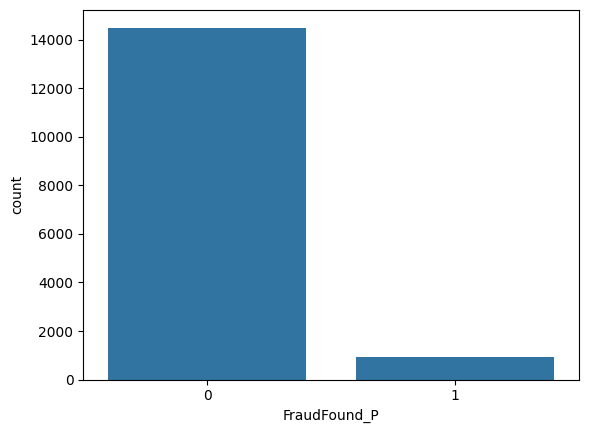

In [20]:
sns.countplot(data=df, x='FraudFound_P')
plt.show()

In [21]:
numerical_columns = df.select_dtypes('integer').columns
obj_columns = df.select_dtypes('object').columns

In [22]:
print(numerical_columns)
print(obj_columns)

Index(['WeekOfMonth', 'WeekOfMonthClaimed', 'Age', 'FraudFound_P',
       'PolicyNumber', 'RepNumber', 'Deductible', 'DriverRating', 'Year'],
      dtype='object')
Index(['Month', 'DayOfWeek', 'Make', 'AccidentArea', 'DayOfWeekClaimed',
       'MonthClaimed', 'Sex', 'MaritalStatus', 'Fault', 'PolicyType',
       'VehicleCategory', 'VehiclePrice', 'Days_Policy_Accident',
       'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle',
       'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType',
       'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars',
       'BasePolicy'],
      dtype='object')


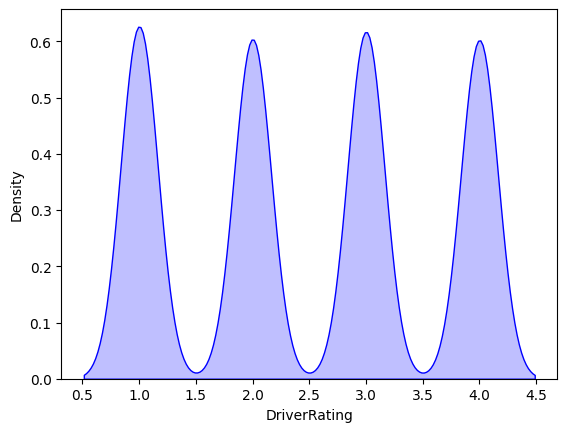

In [23]:
sns.kdeplot(df['DriverRating'], color='blue', fill=True)
plt.show()

## Data Cleaning

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int8  
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int8  
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int8  
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

In [25]:
df.isna().sum()

Month                   0
WeekOfMonth             0
DayOfWeek               0
Make                    0
AccidentArea            0
DayOfWeekClaimed        0
MonthClaimed            0
WeekOfMonthClaimed      0
Sex                     0
MaritalStatus           0
Age                     0
Fault                   0
PolicyType              0
VehicleCategory         0
VehiclePrice            0
FraudFound_P            0
PolicyNumber            0
RepNumber               0
Deductible              0
DriverRating            0
Days_Policy_Accident    0
Days_Policy_Claim       0
PastNumberOfClaims      0
AgeOfVehicle            0
AgeOfPolicyHolder       0
PoliceReportFiled       0
WitnessPresent          0
AgentType               0
NumberOfSuppliments     0
AddressChange_Claim     0
NumberOfCars            0
Year                    0
BasePolicy              0
dtype: int64

In [26]:
for column in obj_columns:
    print(f"Distribution for '{column}':\n{df[column].value_counts()}")

print("\nSummary Statistics of Numerical Features:\n")
df[numerical_columns].describe()

Distribution for 'Month':
Month
Jan    1411
May    1367
Mar    1360
Jun    1321
Oct    1305
Dec    1285
Apr    1280
Feb    1266
Jul    1257
Sep    1240
Nov    1201
Aug    1127
Name: count, dtype: int64
Distribution for 'DayOfWeek':
DayOfWeek
Monday       2616
Friday       2445
Tuesday      2300
Thursday     2173
Wednesday    2159
Saturday     1982
Sunday       1745
Name: count, dtype: int64
Distribution for 'Make':
Make
Pontiac      3837
Toyota       3121
Honda        2801
Mazda        2354
Chevrolet    1681
Accura        472
Ford          450
VW            283
Dodge         109
Saab          108
Mercury        83
Saturn         58
Nisson         30
BMW            15
Jaguar          6
Porche          5
Mecedes         4
Ferrari         2
Lexus           1
Name: count, dtype: int64
Distribution for 'AccidentArea':
AccidentArea
Urban    13822
Rural     1598
Name: count, dtype: int64
Distribution for 'DayOfWeekClaimed':
DayOfWeekClaimed
Monday       3757
Tuesday      3375
Wednesday    295

,WeekOfMonth,WeekOfMonthClaimed,Age,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Year
count,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000
mean,2.788586,2.693969,39.855707,0.059857,7710.500000,8.483268,407.704280,2.487808,1994.866472
std,1.287585,1.259115,13.492377,0.237230,4451.514911,4.599948,43.950998,1.119453,0.803313
min,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,300.000000,1.000000,1994.000000
25%,2.000000,2.000000,31.000000,0.000000,3855.750000,5.000000,400.000000,1.000000,1994.000000
50%,3.000000,3.000000,38.000000,0.000000,7710.500000,8.000000,400.000000,2.000000,1995.000000
75%,4.000000,4.000000,48.000000,0.000000,11565.250000,12.000000,400.000000,3.000000,1996.000000
max,5.000000,5.000000,80.000000,1.000000,15420.000000,16.000000,700.000000,4.000000,1996.000000


In [27]:
#Check unique values for time-based features
print('Year',df['Year'].unique())
print('Month',df['Month'].unique())
print('WeekOfMonth',df['WeekOfMonth'].unique())
print('DayOfWeek',df['DayOfWeek'].unique())
print('DayOfWeekClaimed',df['DayOfWeekClaimed'].unique())
print('MonthClaimed',df['MonthClaimed'].unique())
print('WeekOfMonthClaimed',df['WeekOfMonthClaimed'].unique())

Year [1994 1995 1996]
Month ['Dec' 'Jan' 'Oct' 'Jun' 'Feb' 'Nov' 'Apr' 'Mar' 'Aug' 'Jul' 'May' 'Sep']
WeekOfMonth [5 3 2 4 1]
DayOfWeek ['Wednesday' 'Friday' 'Saturday' 'Monday' 'Tuesday' 'Sunday' 'Thursday']
DayOfWeekClaimed ['Tuesday' 'Monday' 'Thursday' 'Friday' 'Wednesday' 'Saturday' 'Sunday'
 '0']
MonthClaimed ['Jan' 'Nov' 'Jul' 'Feb' 'Mar' 'Dec' 'Apr' 'Aug' 'May' 'Jun' 'Sep' 'Oct'
 '0']
WeekOfMonthClaimed [1 4 2 3 5]


In [28]:
#Drop entry where DayOfWeekClaimed = 0
df_new = df.loc[df['DayOfWeekClaimed']!='0']

In [29]:
#Check unique values for time-based features
print('Year',df_new['Year'].unique())
print('Month',df_new['Month'].unique())
print('WeekOfMonth',df_new['WeekOfMonth'].unique())
print('DayOfWeek',df_new['DayOfWeek'].unique())
print('DayOfWeekClaimed',df_new['DayOfWeekClaimed'].unique())
print('MonthClaimed',df_new['MonthClaimed'].unique())
print('WeekOfMonthClaimed',df_new['WeekOfMonthClaimed'].unique())

Year [1994 1995 1996]
Month ['Dec' 'Jan' 'Oct' 'Jun' 'Feb' 'Nov' 'Apr' 'Mar' 'Aug' 'Jul' 'May' 'Sep']
WeekOfMonth [5 3 2 4 1]
DayOfWeek ['Wednesday' 'Friday' 'Saturday' 'Monday' 'Tuesday' 'Sunday' 'Thursday']
DayOfWeekClaimed ['Tuesday' 'Monday' 'Thursday' 'Friday' 'Wednesday' 'Saturday' 'Sunday']
MonthClaimed ['Jan' 'Nov' 'Jul' 'Feb' 'Mar' 'Dec' 'Apr' 'Aug' 'May' 'Jun' 'Sep' 'Oct']
WeekOfMonthClaimed [1 4 2 3 5]


In [30]:
# Convert Deductible column to object Convert 
df["Deductible"] = df["Deductible"].astype("object")

# Feature Engineering

In [31]:
for col in obj_columns:
    #enc = OneHotEncoder()
    pass
    

# Exploration of Data

Nadine - Year, Month, WeekOfMonth, DayOfWeek, DayOfWeekClaimed, MonthClaimed, WeekOfMonthClaimed


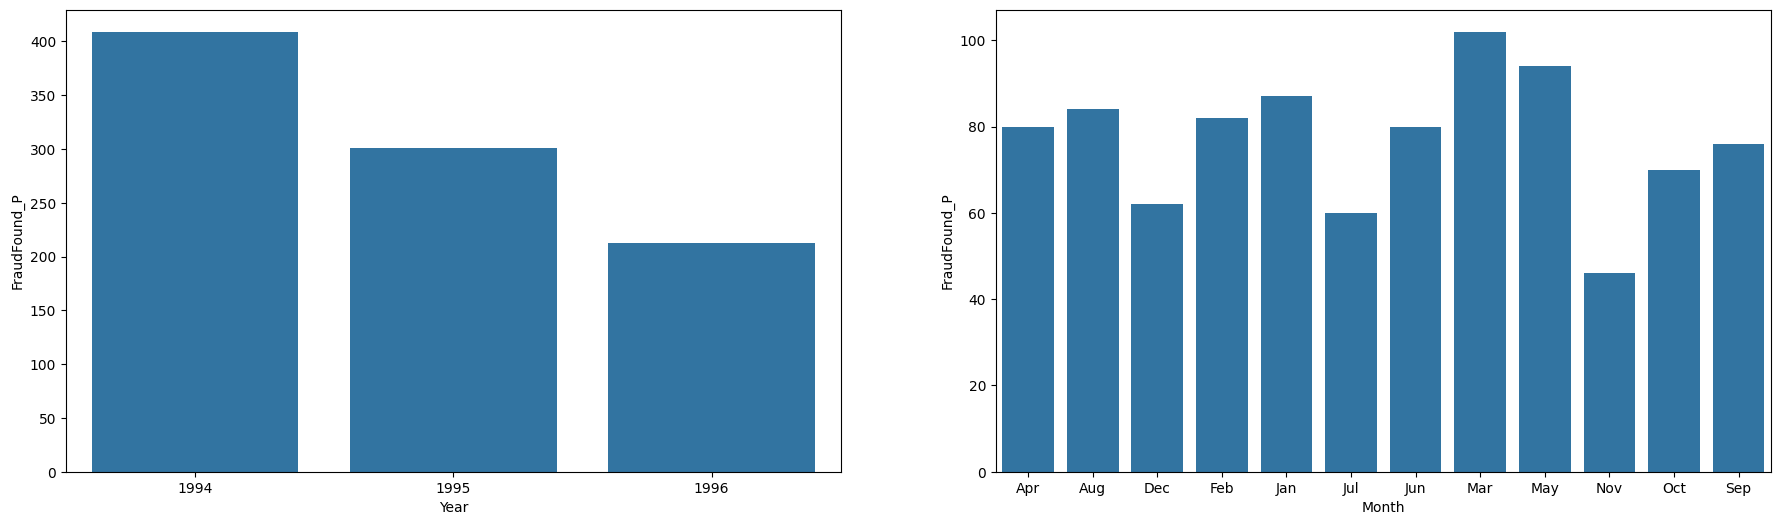

In [32]:
year_vis=df_new.groupby('Year').agg({'FraudFound_P':'sum'}).reset_index()
month_vis = df_new.groupby('Month').agg({'FraudFound_P':'sum'}).reset_index()
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(22, 6))
sns.barplot(x='Year', y='FraudFound_P', data = year_vis, ax=ax1)
sns.barplot(x='Month', y='FraudFound_P', data = month_vis, ax=ax2)

Week of Month, Day of Week

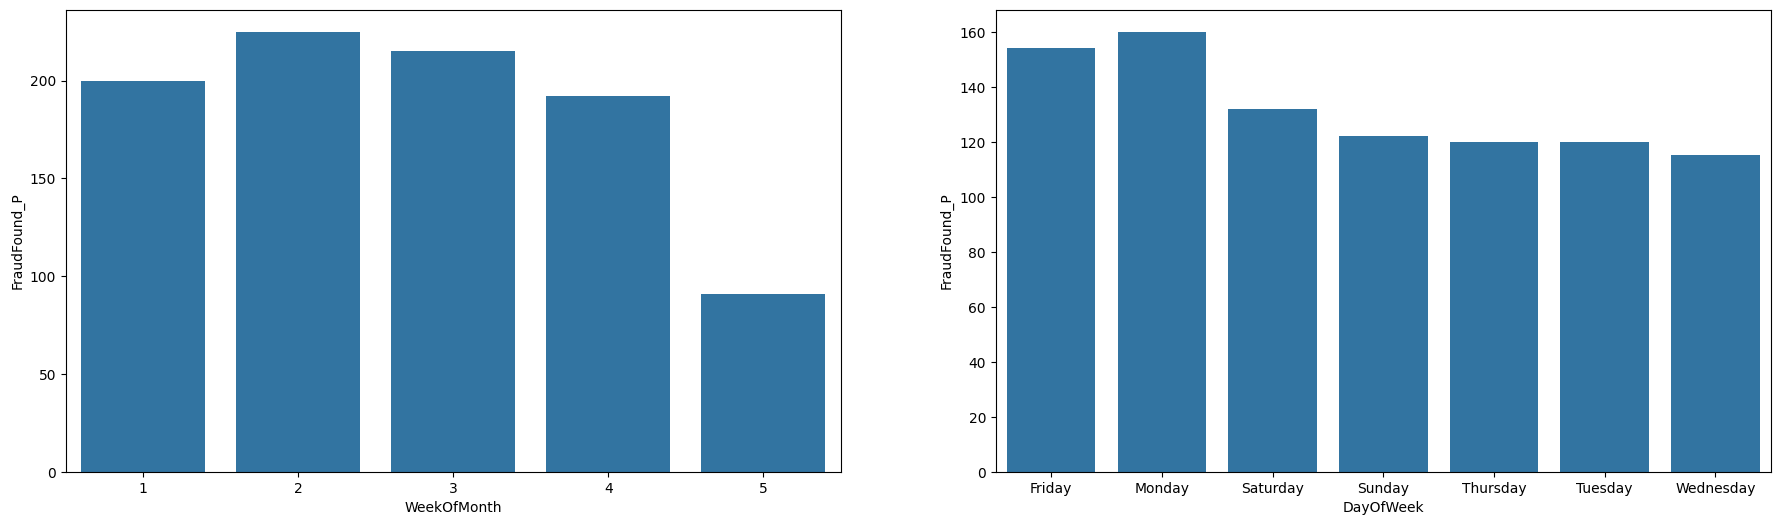

In [33]:
week_of_month_vis=df_new.groupby('WeekOfMonth').agg({'FraudFound_P':'sum'}).reset_index()
day_of_week_vis = df_new.groupby('DayOfWeek').agg({'FraudFound_P':'sum'}).reset_index()
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(22, 6))
sns.barplot(x='WeekOfMonth', y='FraudFound_P', data = week_of_month_vis, ax=ax1)
sns.barplot(x='DayOfWeek', y='FraudFound_P', data = day_of_week_vis, ax=ax2)

Month Claimed, Week of Month Claimed and Day of Week Claimed

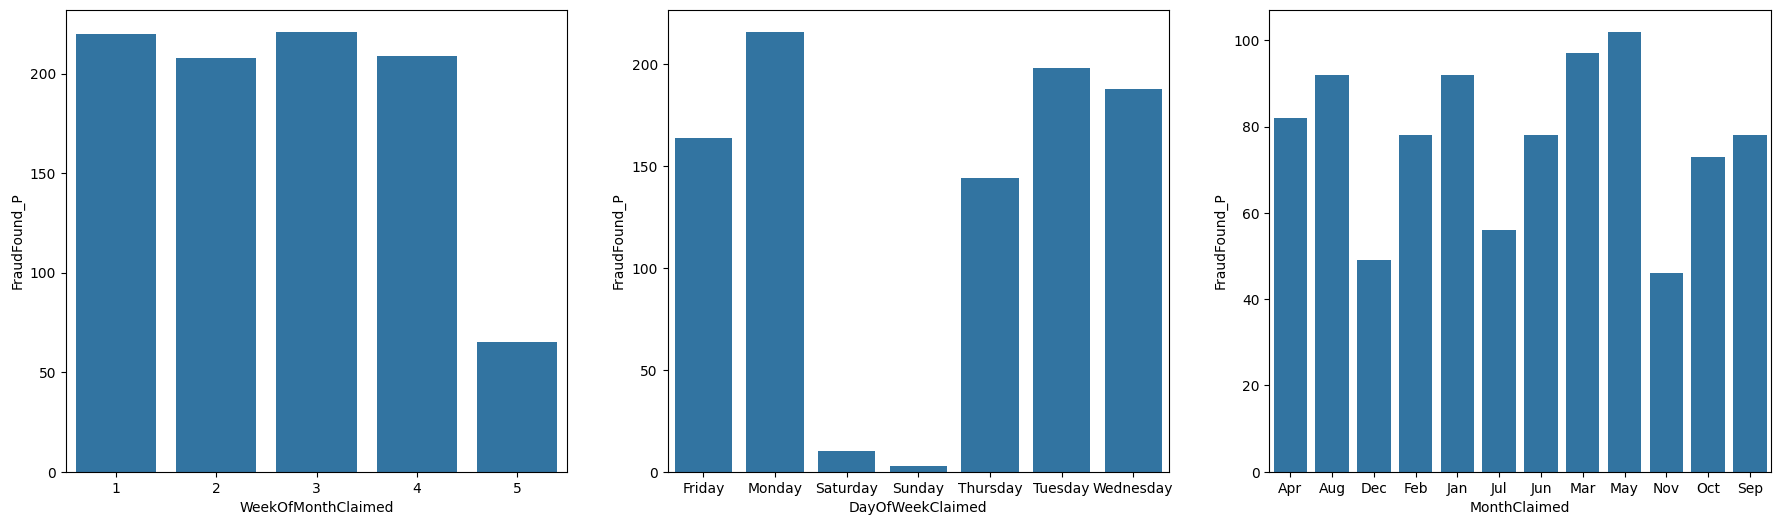

In [34]:
week_of_month_claimed_vis=df_new.groupby('WeekOfMonthClaimed').agg({'FraudFound_P':'sum'}).reset_index()
day_of_week_claimed_vis=df_new.groupby('DayOfWeekClaimed').agg({'FraudFound_P':'sum'}).reset_index()
month_claimed_vis = df_new.groupby('MonthClaimed').agg({'FraudFound_P':'sum'}).reset_index()


fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(22, 6));

sns.barplot(x='WeekOfMonthClaimed', y='FraudFound_P', data = week_of_month_claimed_vis, ax=ax1);
sns.barplot(x='DayOfWeekClaimed', y='FraudFound_P', data = day_of_week_claimed_vis, ax=ax2);
sns.barplot(x='MonthClaimed', y='FraudFound_P', data = month_claimed_vis , ax=ax3);

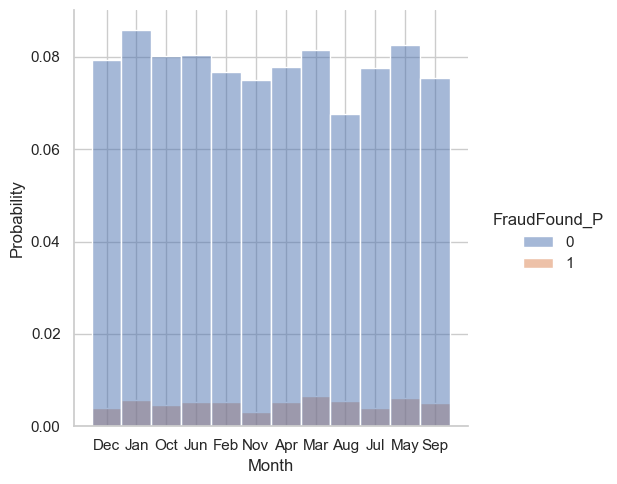

In [132]:
sns.displot(x='Month', hue = "FraudFound_P", stat="probability", data=df_new)

plt.show()

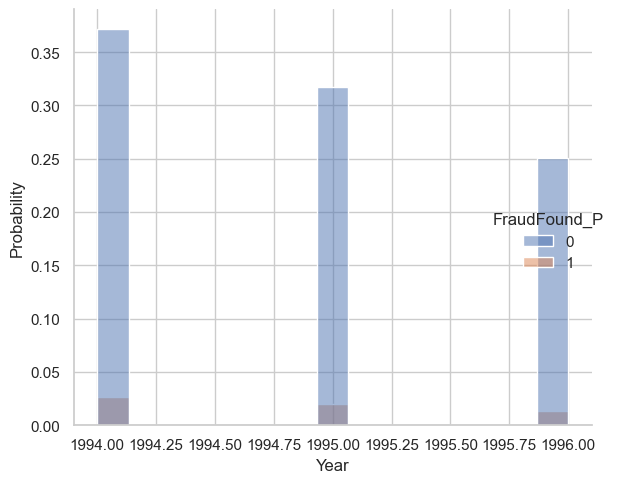

In [134]:
sns.displot(x='Year', hue = "FraudFound_P", stat="probability", data=df_new)
plt.tight_layout()
plt.show()

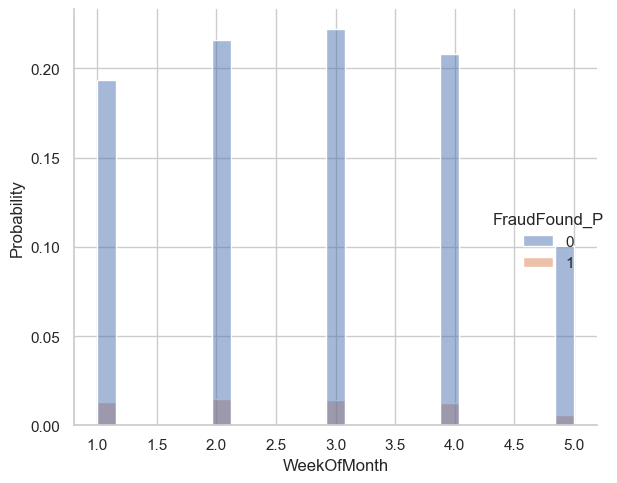

In [135]:
sns.displot(x='WeekOfMonth', hue = "FraudFound_P", stat="probability", data=df_new)
plt.tight_layout()
plt.show()

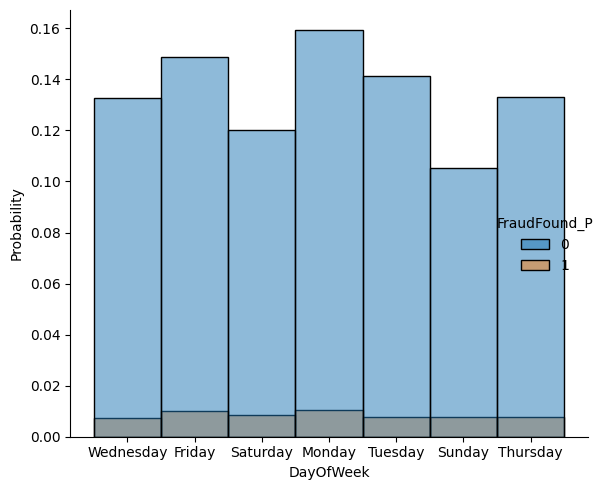

In [38]:
sns.displot(x='DayOfWeek', hue = "FraudFound_P", stat="probability", data=df_new)
plt.tight_layout()
plt.show()

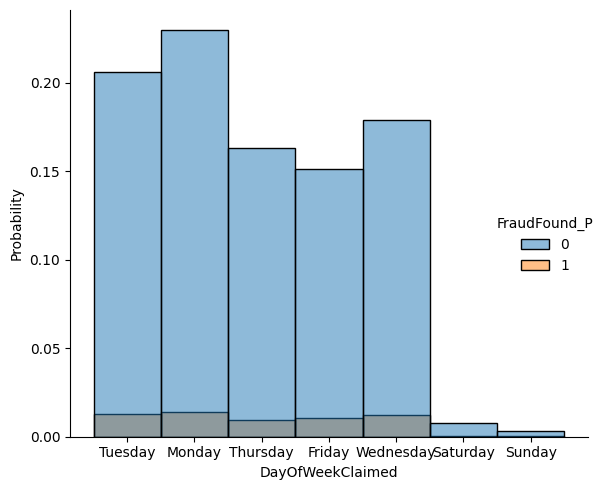

In [39]:
sns.displot(x='DayOfWeekClaimed', hue = "FraudFound_P", stat="probability", data=df_new)
plt.tight_layout()
plt.show()

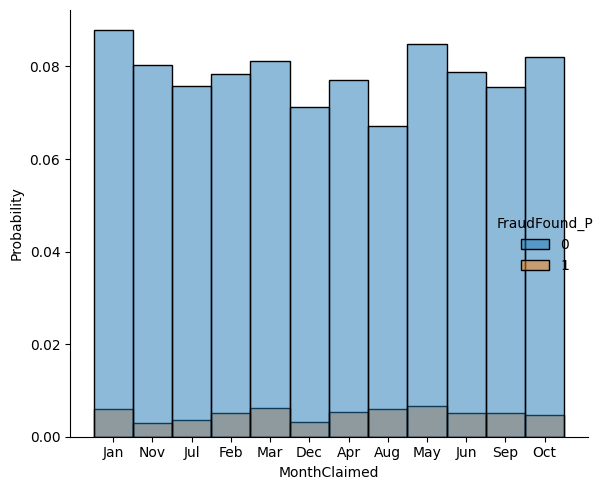

In [40]:
sns.displot(x='MonthClaimed', hue = "FraudFound_P", stat="probability", data=df_new)
plt.tight_layout()
plt.show()

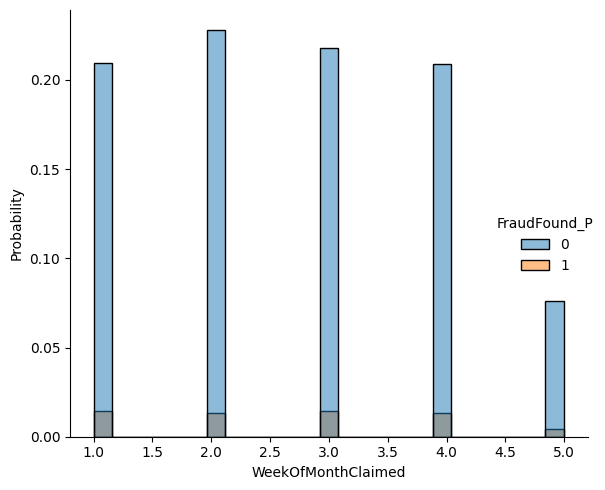

In [41]:
sns.displot(x='WeekOfMonthClaimed', hue = "FraudFound_P", stat="probability", data=df_new)
plt.tight_layout()
plt.show()

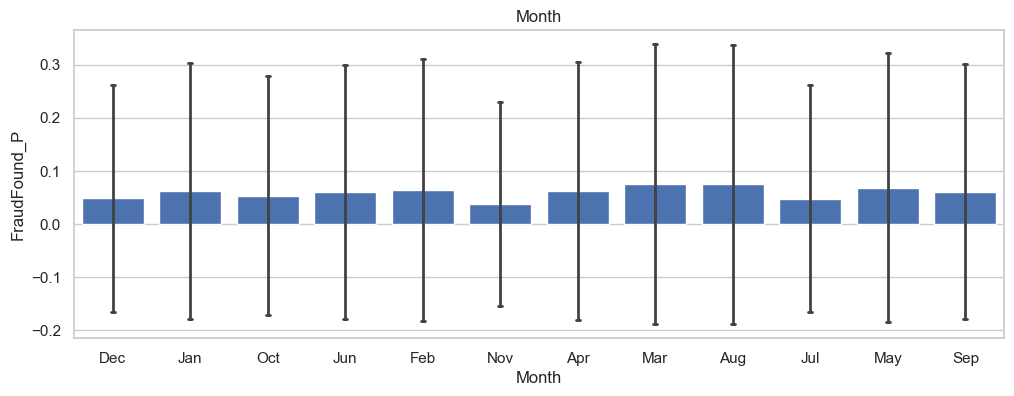

In [136]:
df_new.loc[:, 'FraudFound_P'] = pd.to_numeric(df_new['FraudFound_P'], errors='coerce')

# Check for any missing or invalid values
if df_new['FraudFound_P'].isnull().any():
    print("Warning: 'FraudFound_P' column contains missing or invalid values.")

# Plot barplots
for i in ['Month']:
    sns.set(style="whitegrid"); 
    plt.figure(figsize=(12,4));
    ax = sns.barplot(x=i, y='FraudFound_P', data=df_new, capsize=0.05, saturation=8, err_kws={'linewidth': 2}, errorbar='sd');
    ax.set(title=i);

  

    plt.show();

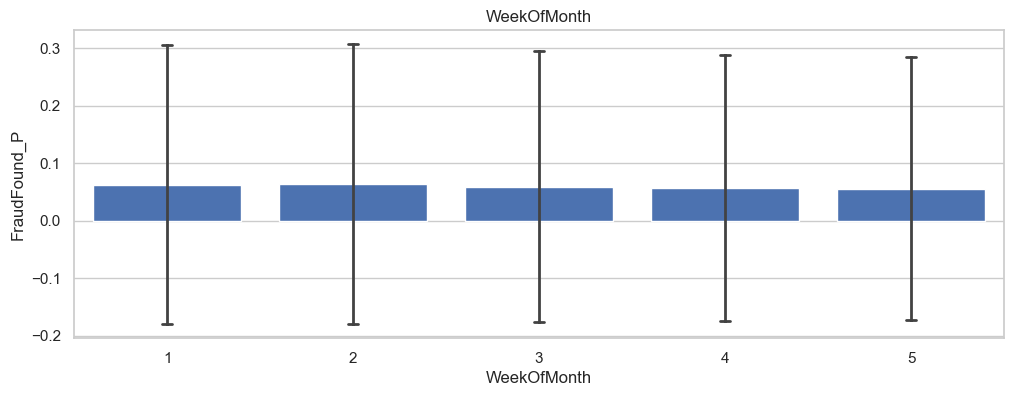

In [43]:
df_new.loc[:, 'FraudFound_P'] = pd.to_numeric(df_new['FraudFound_P'], errors='coerce')

# Check for any missing or invalid values
if df_new['FraudFound_P'].isnull().any():
    print("Warning: 'FraudFound_P' column contains missing or invalid values.")

# Plot barplots
for i in ['WeekOfMonth']:
    sns.set(style="whitegrid"); 
    plt.figure(figsize=(12,4));
    ax = sns.barplot(x=i, y='FraudFound_P', data=df_new, capsize=0.05, saturation=8, err_kws={'linewidth': 2}, errorbar='sd');
    ax.set(title=i);

  

    plt.show();

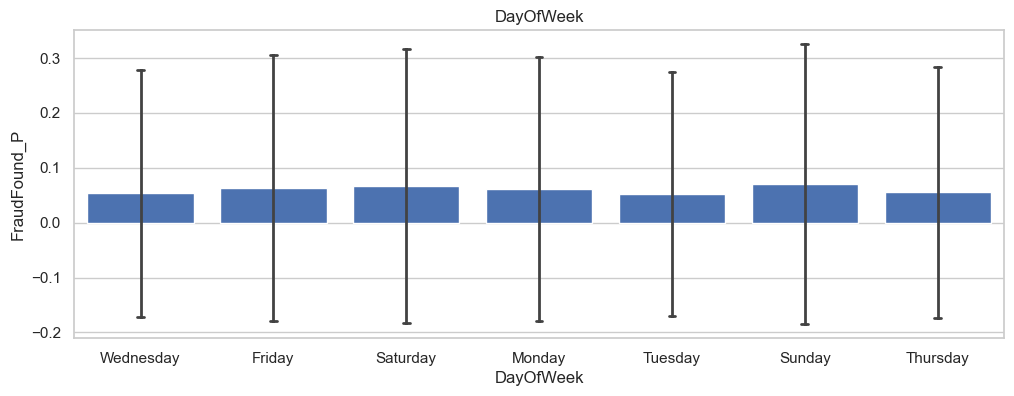

In [44]:
df_new.loc[:, 'FraudFound_P'] = pd.to_numeric(df_new['FraudFound_P'], errors='coerce')

# Check for any missing or invalid values
if df_new['FraudFound_P'].isnull().any():
    print("Warning: 'FraudFound_P' column contains missing or invalid values.")

# Plot barplots
for i in ['DayOfWeek']:
    sns.set(style="whitegrid"); 
    plt.figure(figsize=(12,4));
    ax = sns.barplot(x=i, y='FraudFound_P', data=df_new, capsize=0.05, saturation=8, err_kws={'linewidth': 2}, errorbar='sd');
    ax.set(title=i);

  

    plt.show();

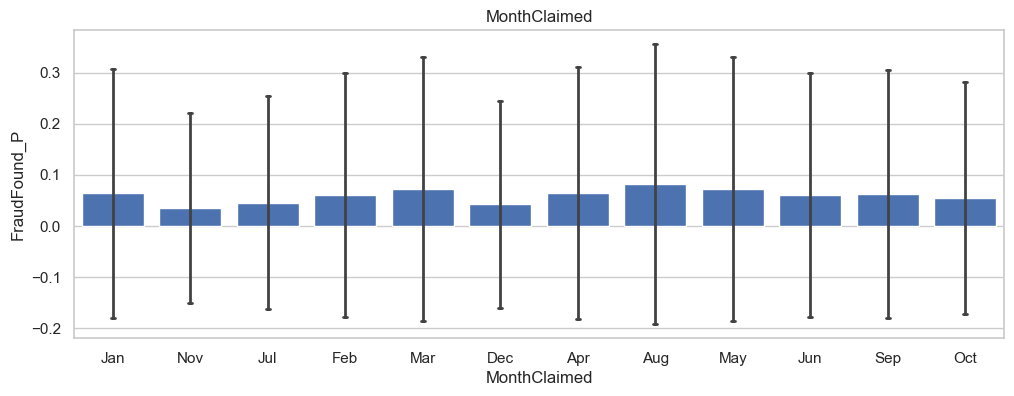

In [45]:
df_new.loc[:, 'FraudFound_P'] = pd.to_numeric(df_new['FraudFound_P'], errors='coerce')

# Check for any missing or invalid values
if df_new['FraudFound_P'].isnull().any():
    print("Warning: 'FraudFound_P' column contains missing or invalid values.")

# Plot barplots
for i in ['MonthClaimed']:
    sns.set(style="whitegrid"); 
    plt.figure(figsize=(12,4));
    ax = sns.barplot(x=i, y='FraudFound_P', data=df_new, capsize=0.05, saturation=8, err_kws={'linewidth': 2}, errorbar='sd');
    ax.set(title=i);

  

    plt.show();

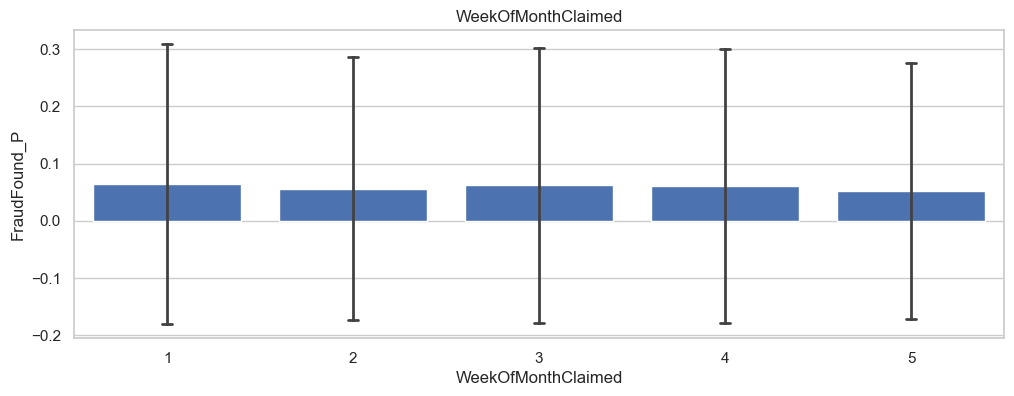

In [46]:
df_new.loc[:, 'FraudFound_P'] = pd.to_numeric(df_new['FraudFound_P'], errors='coerce')

# Check for any missing or invalid values
if df_new['FraudFound_P'].isnull().any():
    print("Warning: 'FraudFound_P' column contains missing or invalid values.")

# Plot barplots
for i in ['WeekOfMonthClaimed']:
    sns.set(style="whitegrid"); 
    plt.figure(figsize=(12,4));
    ax = sns.barplot(x=i, y='FraudFound_P', data=df_new, capsize=0.05, saturation=8, err_kws={'linewidth': 2}, errorbar='sd');
    ax.set(title=i);

  

    plt.show();

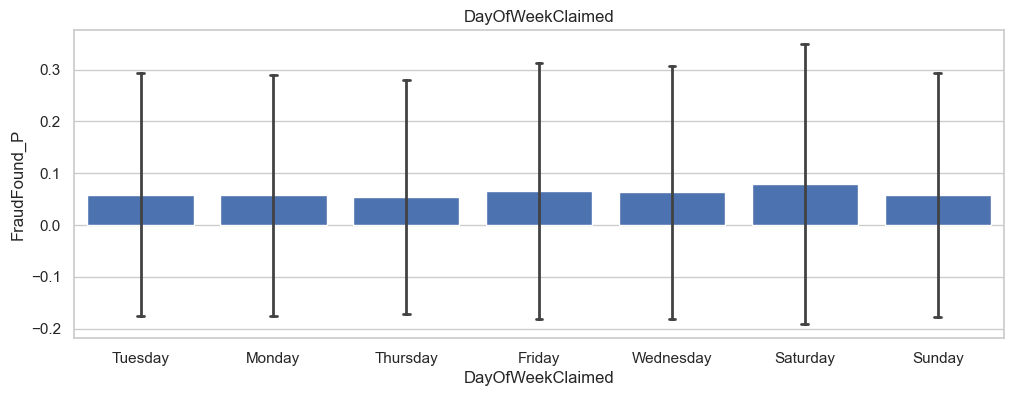

In [47]:
df_new.loc[:, 'FraudFound_P'] = pd.to_numeric(df_new['FraudFound_P'], errors='coerce')

# Check for any missing or invalid values
if df_new['FraudFound_P'].isnull().any():
    print("Warning: 'FraudFound_P' column contains missing or invalid values.")

# Plot barplots
for i in ['DayOfWeekClaimed']:
    sns.set(style="whitegrid"); 
    plt.figure(figsize=(12,4));
    ax = sns.barplot(x=i, y='FraudFound_P', data=df_new, capsize=0.05, saturation=8, err_kws={'linewidth': 2}, errorbar='sd');
    ax.set(title=i);

  

    plt.show();

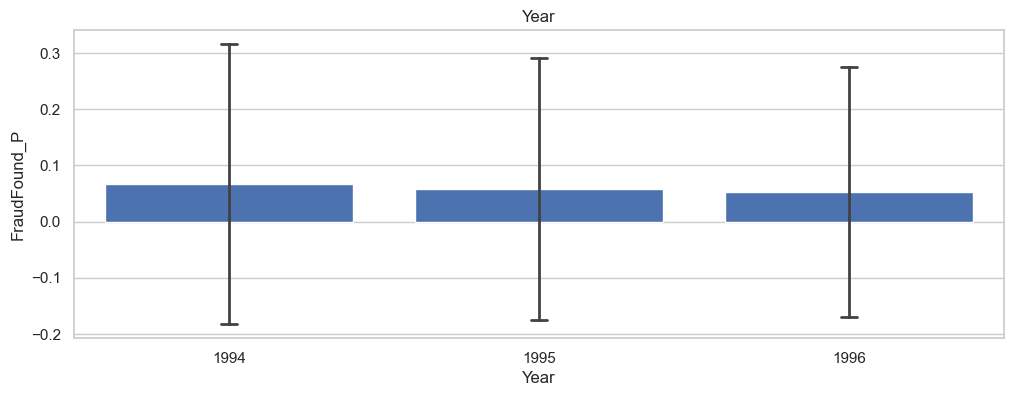

In [48]:
df_new.loc[:, 'FraudFound_P'] = pd.to_numeric(df_new['FraudFound_P'], errors='coerce')

# Check for any missing or invalid values
if df_new['FraudFound_P'].isnull().any():
    print("Warning: 'FraudFound_P' column contains missing or invalid values.")

# Plot barplots
for i in ['Year']:
    sns.set(style="whitegrid"); 
    plt.figure(figsize=(12,4));
    ax = sns.barplot(x=i, y='FraudFound_P', data=df_new, capsize=0.05, saturation=8, err_kws={'linewidth': 2}, errorbar='sd');
    ax.set(title=i);

  

    plt.show();

Based on the plots above, we can observe that there are more incidents recorded in January, and typically occur on the second week of the month and on Mondays. 

Month of March and August had relatively higher percentage of fraudulent transactions within the total claims for those months, although the difference is not significant when comparing with other months. 

In [49]:
contingency_table = pd.crosstab(df_new['Month'], df_new['FraudFound_P'])

chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("Chi-square Test Statistic:", chi2)
print("P-value:", p_value)
print("Degrees of Freedom:", dof)

Chi-square Test Statistic: 29.77146863498089
P-value: 0.001720902092411024
Degrees of Freedom: 11


In [50]:
contingency_table = pd.crosstab(df_new['Year'], df_new['FraudFound_P'])


chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("Chi-square Test Statistic:", chi2)
print("P-value:", p_value)
print("Degrees of Freedom:", dof)

Chi-square Test Statistic: 9.592586963721214
P-value: 0.00826030735692047
Degrees of Freedom: 2


In [51]:
contingency_table = pd.crosstab(df_new['WeekOfMonth'], df_new['FraudFound_P'])


chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("Chi-square Test Statistic:", chi2)
print("P-value:", p_value)
print("Degrees of Freedom:", dof)

Chi-square Test Statistic: 2.454694386485525
P-value: 0.6527664208210411
Degrees of Freedom: 4


In [52]:
contingency_table = pd.crosstab(df_new['DayOfWeek'], df_new['FraudFound_P'])


chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("Chi-square Test Statistic:", chi2)
print("P-value:", p_value)
print("Degrees of Freedom:", dof)

Chi-square Test Statistic: 10.152846103147564
P-value: 0.11836116248221312
Degrees of Freedom: 6


In [53]:
contingency_table = pd.crosstab(df_new['MonthClaimed'], df_new['FraudFound_P'])


chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("Chi-square Test Statistic:", chi2)
print("P-value:", p_value)
print("Degrees of Freedom:", dof)

Chi-square Test Statistic: 42.20051448750482
P-value: 1.4952445828227434e-05
Degrees of Freedom: 11


In [54]:
contingency_table = pd.crosstab(df_new['DayOfWeekClaimed'], df_new['FraudFound_P'])


chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("Chi-square Test Statistic:", chi2)
print("P-value:", p_value)
print("Degrees of Freedom:", dof)

Chi-square Test Statistic: 5.095641306619024
P-value: 0.5316063163312554
Degrees of Freedom: 6


In [55]:
contingency_table = pd.crosstab(df_new['WeekOfMonthClaimed'], df_new['FraudFound_P'])


chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("Chi-square Test Statistic:", chi2)
print("P-value:", p_value)
print("Degrees of Freedom:", dof)

Chi-square Test Statistic: 3.3807221766137063
P-value: 0.4962449267879594
Degrees of Freedom: 4


MonthClaimed, Month seem to be the more significant variables based on the p-value that are below 0.05. We hypothesise that there could be discounts or promotions happening in specific months, that could have incentivised more fraudsters to take advantage of these discounts and commit fraud.

## Cat 2: Make, VehicleCategory, VehiclePrice, AgeOfVehicle, Fault

In [56]:
df_cat2 = df[["Make", "VehicleCategory", "VehiclePrice", "AgeOfVehicle", "Fault", "FraudFound_P"]]
df_cat2.head()

,Make,VehicleCategory,VehiclePrice,AgeOfVehicle,Fault,FraudFound_P
0,Honda,Sport,more than 69000,3 years,Policy Holder,0
1,Honda,Sport,more than 69000,6 years,Policy Holder,0
2,Honda,Sport,more than 69000,7 years,Policy Holder,0
3,Toyota,Sport,20000 to 29000,more than 7,Third Party,0
4,Honda,Sport,more than 69000,5 years,Third Party,0


In [57]:
for col in df_cat2:
    print(f"Unique values for '{col}': {df_cat2[col].unique()}\n")

Unique values for 'Make': ['Honda' 'Toyota' 'Ford' 'Mazda' 'Chevrolet' 'Pontiac' 'Accura' 'Dodge'
 'Mercury' 'Jaguar' 'Nisson' 'VW' 'Saab' 'Saturn' 'Porche' 'BMW' 'Mecedes'
 'Ferrari' 'Lexus']

Unique values for 'VehicleCategory': ['Sport' 'Utility' 'Sedan']

Unique values for 'VehiclePrice': ['more than 69000' '20000 to 29000' '30000 to 39000' 'less than 20000'
 '40000 to 59000' '60000 to 69000']

Unique values for 'AgeOfVehicle': ['3 years' '6 years' '7 years' 'more than 7' '5 years' 'new' '4 years'
 '2 years']

Unique values for 'Fault': ['Policy Holder' 'Third Party']

Unique values for 'FraudFound_P': [0 1]



### Make

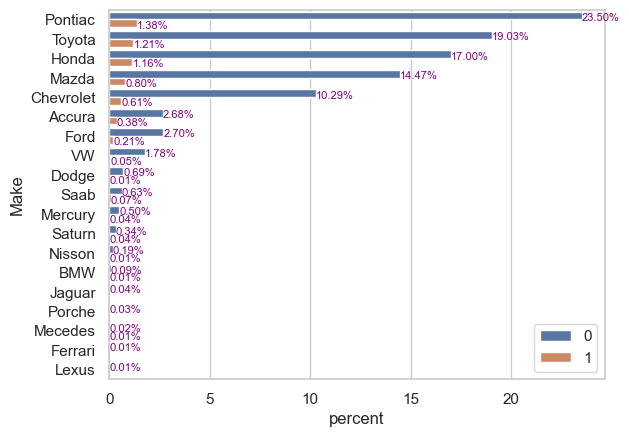

In [58]:
ax = sns.countplot(y="Make", data=df, hue="FraudFound_P", order=df["Make"].value_counts().index, stat="percent")
for p in ax.patches: # Annotating counts (p.get_height) onto graph and formatting their positions 
    value = "{:,.2f}%".format(p.get_width())
    if value != "0.00%":
        ax.annotate(value, (p.get_x() + p.get_width(), p.get_y() + .3), va="center", fontsize=8, c='purple') 
plt.legend(loc="lower right")
plt.show()

The most popular car model involved in accidents is Pontiac, followed by Toyota and Honda. They are also the top 3 most involved in fraud cases

### VehicleCategory

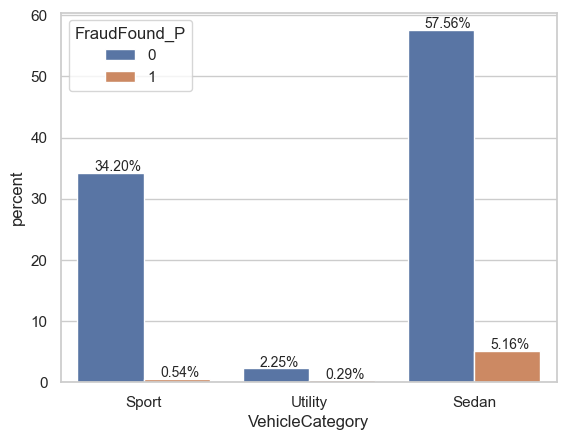

In [59]:
ax = sns.countplot(x="VehicleCategory", data=df, hue="FraudFound_P", stat="percent")
for p in ax.patches: # Annotating counts (p.get_height) onto graph and formatting their positions 
    value = "{:,.2f}%".format(p.get_height())
    if value != "0.00%":
        ax.annotate(value, (p.get_x() + p.get_width() - 0.3, p.get_height() + 1), va="center", fontsize=10) 

plt.show()

Sedans are the most involved in accident claims. That makes sense, as the most popular type of cars we see on the roads are sedans. Hence, it is also the most involved in fraud cases

### VehiclePrice

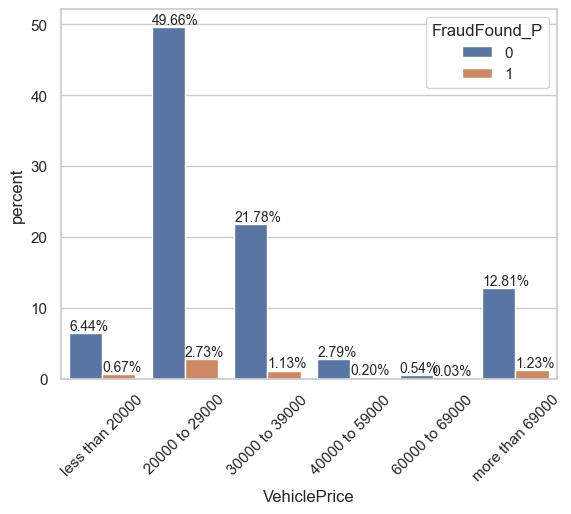

In [60]:
order = ["less than 20000", "20000 to 29000", "30000 to 39000", "40000 to 59000", "60000 to 69000", "more than 69000"]
ax = sns.countplot(x="VehiclePrice", data=df, hue="FraudFound_P", stat="percent", order=order)
for p in ax.patches: # Annotating counts (p.get_height) onto graph and formatting their positions 
    value = "{:,.2f}%".format(p.get_height())
    if value != "0.00%":
        ax.annotate(value, (p.get_x() + p.get_width() - .4, p.get_height() + 1), va="center", fontsize=10) 
plt.xticks(rotation=45)
plt.show()

From the plot, the most popular price of cars involved in insurance fruad is 20,000 to 29,000, followed by > 69,000.

### Make & VehiclePrice
Percentage column shows percentage of each group, grouped by make, vehicleprice and fraudfound_p

In [61]:
df_test = df_cat2.groupby(["Make", "VehiclePrice", "FraudFound_P"]).size().reset_index().rename(columns={0:"NumClaims"})

df_test["group percentage"] = df_test.groupby(["Make", "VehiclePrice"])["NumClaims"].apply(lambda x: round(100 * x / x.sum(), 2)).reset_index()["NumClaims"]

df_test[df_test["FraudFound_P"] == 1].sort_values(by="NumClaims", ascending=False).head(10)

,Make,VehiclePrice,FraudFound_P,NumClaims,group percentage
110,Toyota,20000 to 29000,1,112,5.72
82,Pontiac,20000 to 29000,1,109,4.82
53,Honda,more than 69000,1,78,10.64
58,Mazda,20000 to 29000,1,68,4.91
45,Honda,20000 to 29000,1,63,4.28
89,Pontiac,less than 20000,1,44,10.09
84,Pontiac,30000 to 39000,1,44,4.98
15,Chevrolet,20000 to 29000,1,39,5.41
117,Toyota,less than 20000,1,38,9.38
8,Accura,more than 69000,1,31,19.38


The make and price of vehicles with greatest number of fraud claims is Toyota, between 20,000 to 29,000. It has 112 fradulent claims, which is 5.72% of claims involving Toyotas between 20,000 and 29,000.

### 

### AgeOfVehicle

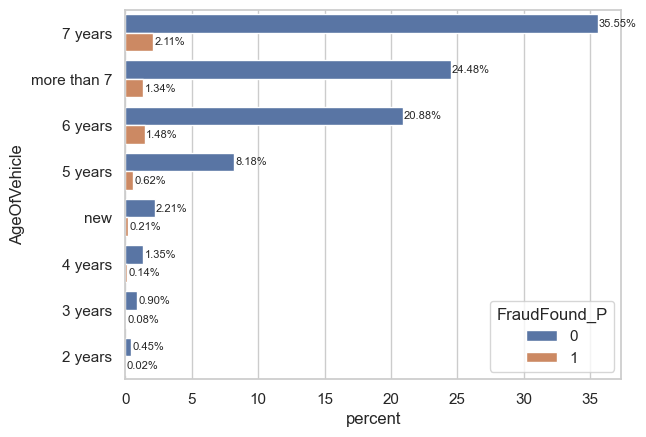

In [62]:
ax = sns.countplot(y="AgeOfVehicle", data=df, hue="FraudFound_P", stat="percent", order=df["AgeOfVehicle"].value_counts().index)
for p in ax.patches: # Annotating counts (p.get_height) onto graph and formatting their positions 
    value = "{:,.2f}%".format(p.get_width())
    if value != "0.00%":
        ax.annotate(value, (p.get_x() + p.get_width() + 0.1, p.get_y() + 0.2), va="center", fontsize=8) 
plt.show()

Older vehicles are more likely to be involved in fraudulent claims; 6 years and above. One reason why newer vehicles are involved in fraud claims could be because of the young age of the vehicle, hence owners will want companies to think that they are less likely to damage their cars in hopes of fradulent claims.

### Fault

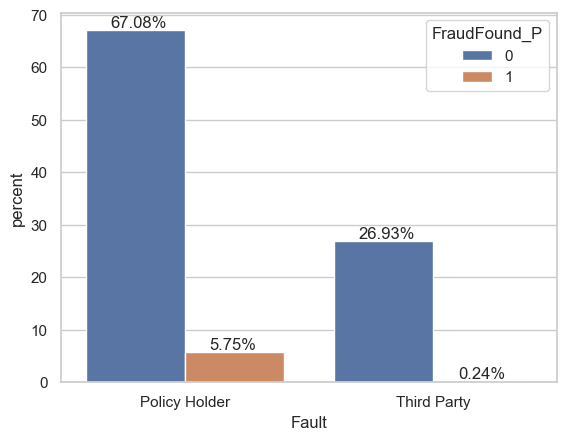

In [63]:
ax = sns.countplot(x="Fault", data=df, hue="FraudFound_P", stat="percent")
for p in ax.patches: # Annotating counts (p.get_height) onto graph and formatting their positions 
    value = "{:,.2f}%".format(p.get_height())
    if value != "0.00%":
        ax.annotate(value, (p.get_x() + p.get_width() - 0.3, p.get_height()+ 1.3), va="center") 
        
plt.show()

For non-fraud cases, 26.93% of accident claims are caused by thirdparty, while 67.08% are caused by policyholder. For fraud cases, only 0.24% are caused by thirdparty, and 5.75% are caused by the policyholder. Policyholders may purposely get into accidents to try and claim insurance

## Cat 3: Sex, MaritalStatus, Age, AgentType, WitnessPresent, DriverRating, AccidentArea, PoliceReportFiled, NumberOfCars (owned) 

### Number of fraud cases per driver rating

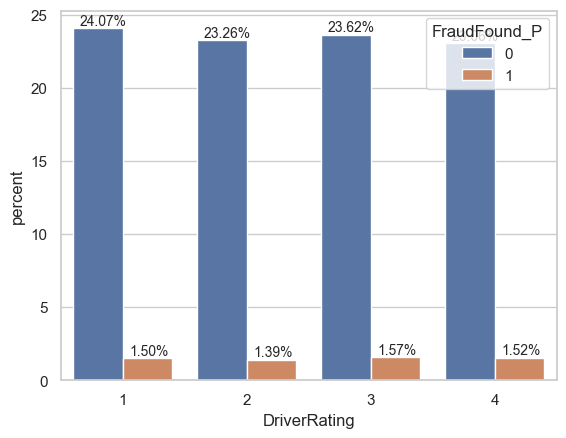

In [64]:
ax = sns.countplot(x="DriverRating", data=df, hue="FraudFound_P", stat="percent")
for p in ax.patches: # Annotating counts (p.get_height) onto graph and formatting their positions 
    value = "{:,.2f}%".format(p.get_height())
    if value != "0.00%":
        ax.annotate(value, (p.get_x() + p.get_width() - 0.35, p.get_height() + 0.5), va="center", fontsize=10) 

plt.show()

Driver ratings are all similar in values for both non-fraud and fraud cases. This feature alone may not be very important in helping us determine which case is fraud or not.

### AccidentArea and WitnessPresent

<Axes: xlabel='AccidentArea', ylabel='FraudFound_P'>

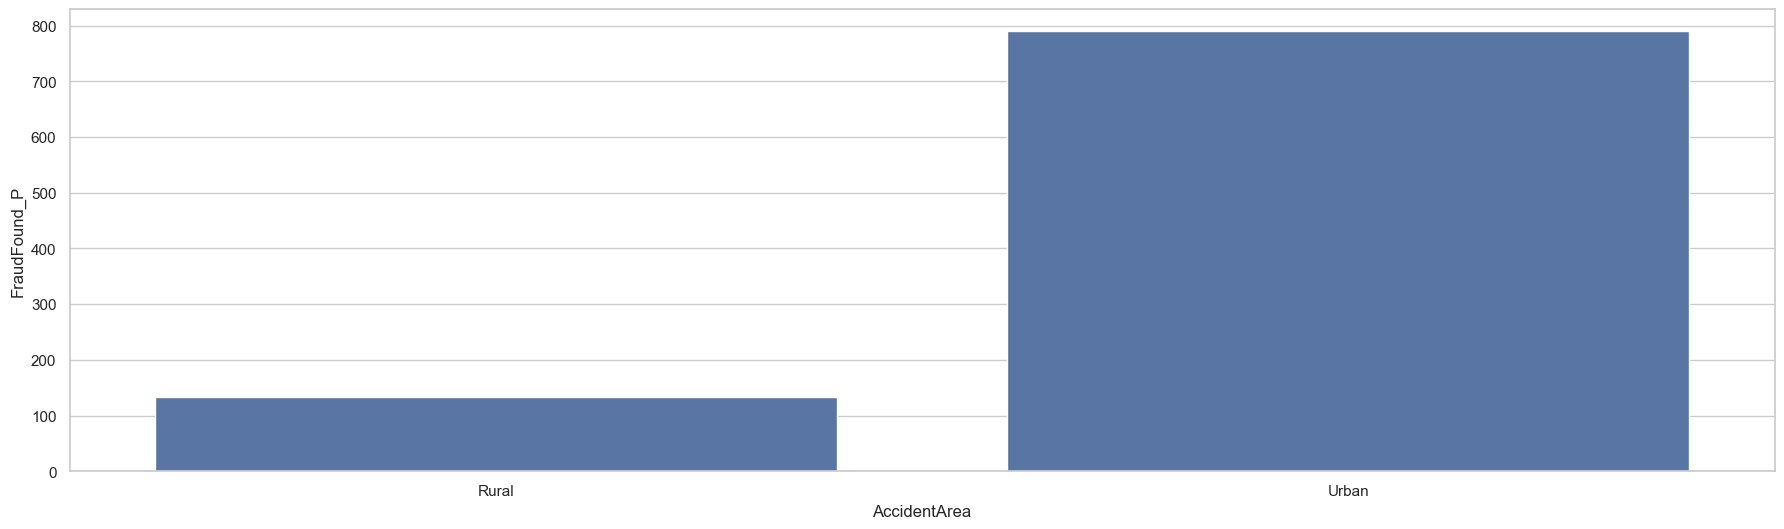

In [65]:
accident_area_vis=df.groupby('AccidentArea').agg({'FraudFound_P':'sum'}).reset_index()
fig, (ax1) = plt.subplots(1,1,figsize=(22, 6))
sns.barplot(x='AccidentArea', y='FraudFound_P', data = accident_area_vis, ax=ax1)

<Axes: xlabel='WitnessPresent', ylabel='FraudFound_P'>

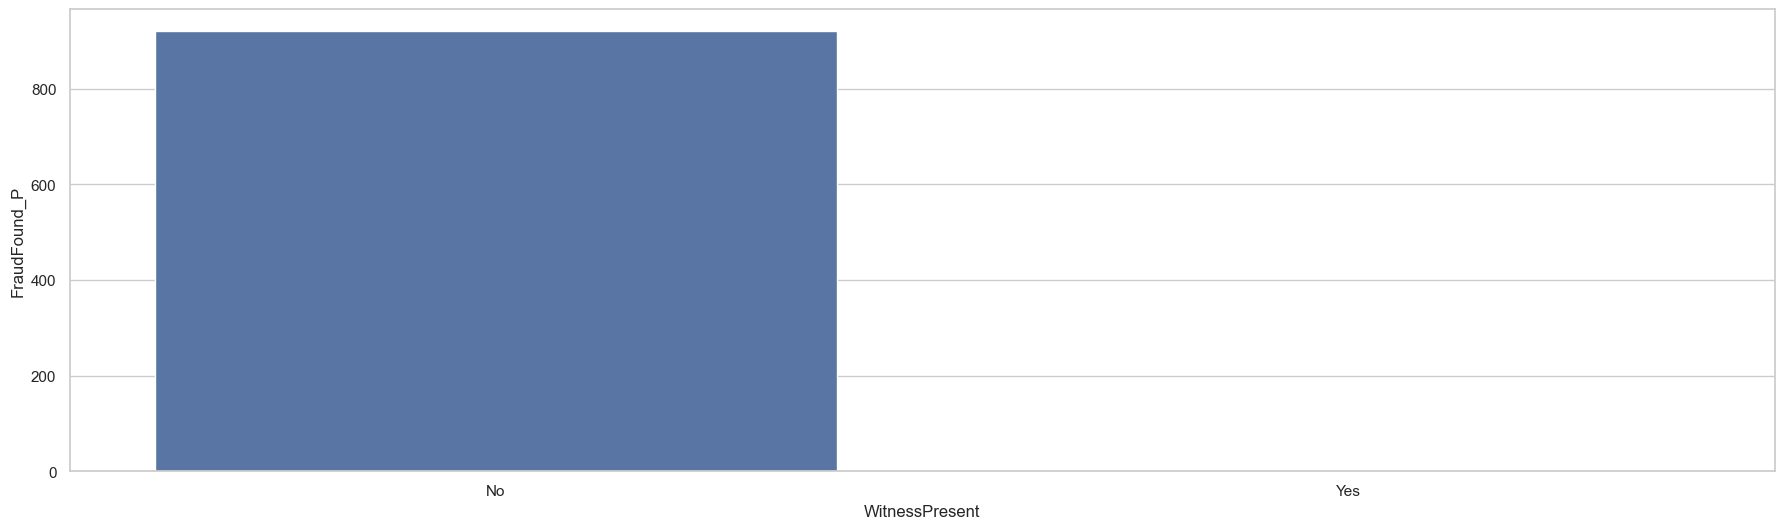

In [66]:
witness_present_vis=df_new.groupby('WitnessPresent').agg({'FraudFound_P':'sum'}).reset_index()
fig, (ax1) = plt.subplots(1,1,figsize=(22, 6))
sns.barplot(x='WitnessPresent', y='FraudFound_P', data = witness_present_vis, ax=ax1)

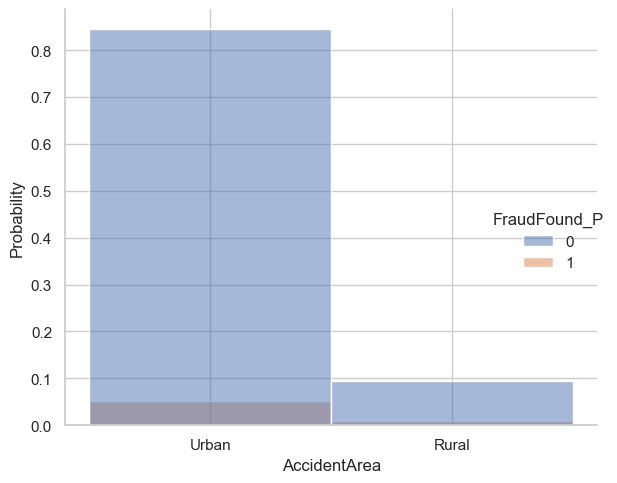

In [67]:
sns.displot(x='AccidentArea', hue = "FraudFound_P", stat="probability", data=df_new)
plt.tight_layout()
plt.show()

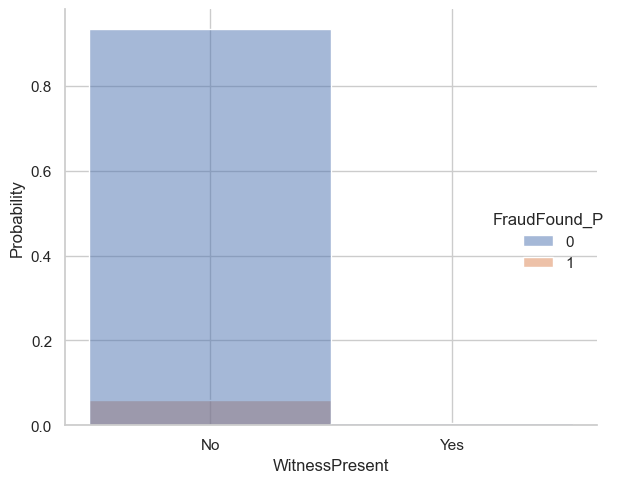

In [68]:
sns.displot(x='WitnessPresent', hue = "FraudFound_P", stat="probability", data=df_new)
plt.tight_layout()
plt.show()

In [69]:
def dist_by_col(col, figsize):
    fig, axs = plt.subplots(ncols=2, figsize=figsize)
    sns.countplot(x=col, data=df, hue=col, legend=False, ax = axs[0])

    labels = ['No Fraud', 'Fraud']
    sns.countplot(x=col,hue="FraudFound_P" ,data=df, palette={0:"forestgreen",1:"orangered"}, ax = axs[1])
    plt.legend(labels)
    plt.title(f'Fraud distribution by {col}')
    plt.show()

def fraud_percentage(col, height=4, aspect=1):
    percent = df.groupby([col,'FraudFound_P']).size().reset_index().rename(columns={0: "size"})
    percent["Fraud Percentage"] = percent.groupby(col)["size"].apply(lambda x: round(100 * x / x.sum(), 2)).reset_index()["size"]
    g = sns.catplot(data = percent, x = col, y="Fraud Percentage", hue="FraudFound_P", palette={0:"forestgreen",1:"orangered"}, height=height, aspect=aspect, kind="bar")
    ax = g.facet_axis(0, 0)  # or ax = g.axes.flat[0]

    # iterate through the axes containers
    for c in ax.containers:
        labels = [f'{(v.get_height()):.2f}%' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
    plt.show()

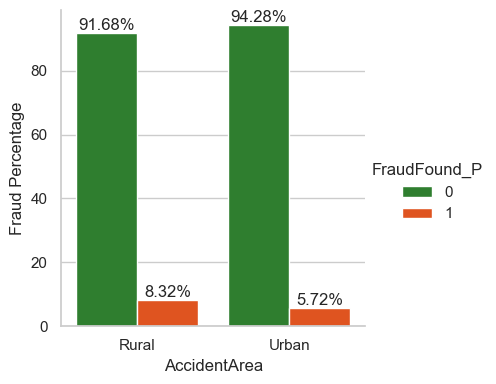

In [70]:
fraud_percentage("AccidentArea")

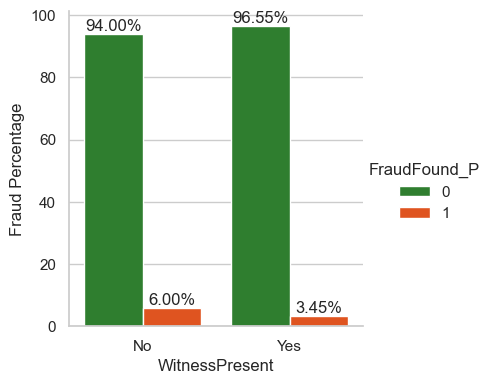

In [71]:
fraud_percentage("WitnessPresent")

At first glance, we can see that there are significantly more accidents that were recorded to have occurred in urban areas as compared to rural areas. Also, the probability of fraudulent claims where the accident is recorded in urban areas is much higher than rural areas.

This is plausible given that urban areas have more transportation services and roads, and traffic incidents are more likely to occur there. For rural areas where there are less roads, it is more likely that accidents there are less common and hence fraudulent claims where accidents are recorded to be from rural areas will appear more suspicious.

We also observe that there are more accidents recorded with no witnesses present, and at the same time, higher fraud probability. 

This is also reasonable since witnesses present at accident sites could facilitate investigations by providing key information or even evidence about the accident, leading to lower probability of fraud. In comparison, fraudsters are more able to fake or exaggerate information about accidents if they were to be acting alone, with no witnesses to disprove their claims.

However, we also do not discount the possiblity that witnesses present at the accident site could be accomplices by providing false information to facilitate fraud.

### AgentType, MaritalStatus

In [72]:
def dist_by_col(col, figsize):
    fig, axs = plt.subplots(ncols=2, figsize=figsize)
    sns.countplot(x=col, data=df, hue=col, legend=False, ax = axs[0])

    labels = ['No Fraud', 'Fraud']
    sns.countplot(x=col,hue="FraudFound_P" ,data=df, palette={0:"forestgreen",1:"orangered"}, ax = axs[1])
    plt.legend(labels)
    plt.title(f'Fraud distribution by {col}')
    plt.show()

def fraud_percentage(col, height=4, aspect=1):
    percent = df.groupby([col,'FraudFound_P']).size().reset_index().rename(columns={0: "size"})
    percent["Fraud Percentage"] = percent.groupby(col)["size"].apply(lambda x: round(100 * x / x.sum(), 2)).reset_index()["size"]
    g = sns.catplot(data = percent, x = col, y="Fraud Percentage", hue="FraudFound_P", palette={0:"forestgreen",1:"orangered"}, height=height, aspect=aspect, kind="bar")
    ax = g.facet_axis(0, 0)  # or ax = g.axes.flat[0]

    # iterate through the axes containers
    for c in ax.containers:
        labels = [f'{(v.get_height()):.2f}%' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
    plt.show()

### AgentType

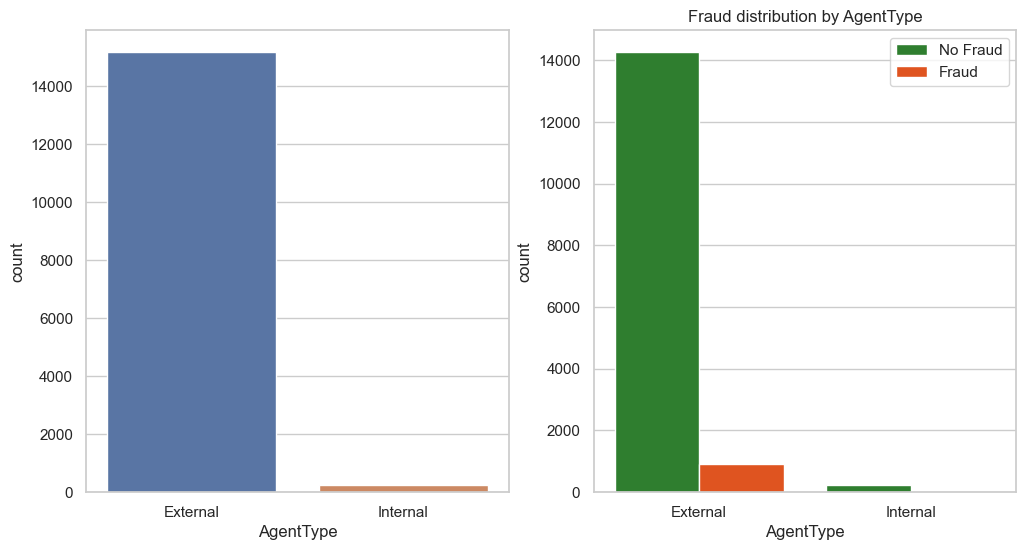

In [73]:
dist_by_col("AgentType", (12,6))

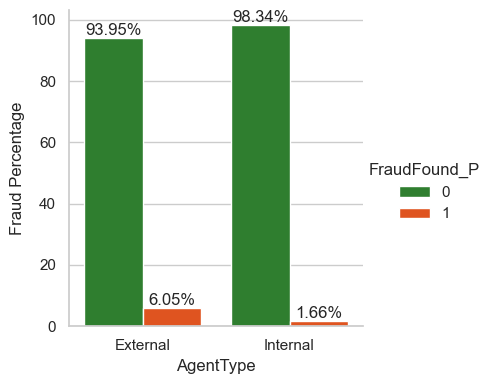

In [74]:
fraud_percentage("AgentType")

Fraud percentage for internal agents are is lower than for external agents. This might be because it is harder to control/regulate external agents for an insurance company and might also be harder to enforce punishments if the agent do not belong to the company itself. So external agents are more tempted to conduct fraud

### MaritalStatus

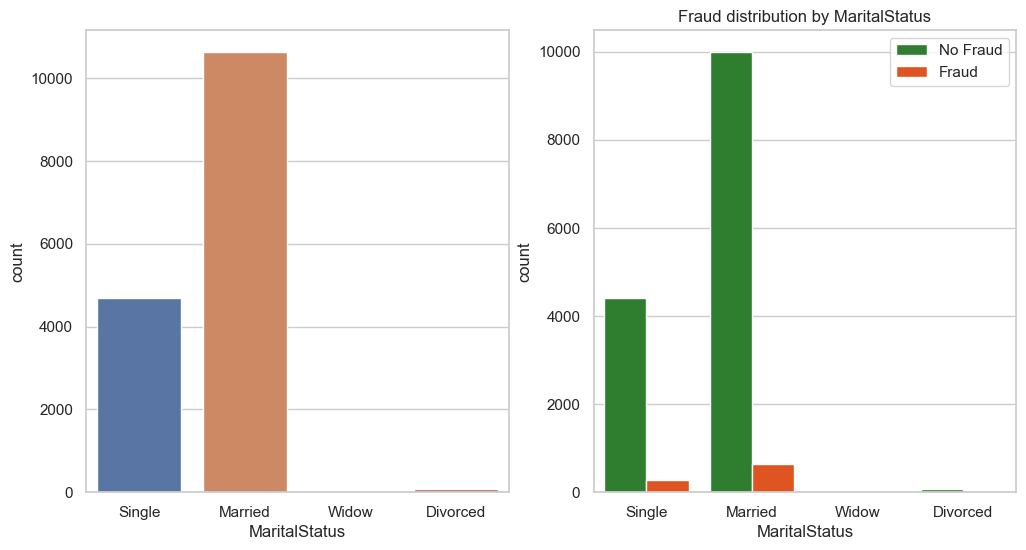

In [75]:
dist_by_col("MaritalStatus", (12,6))

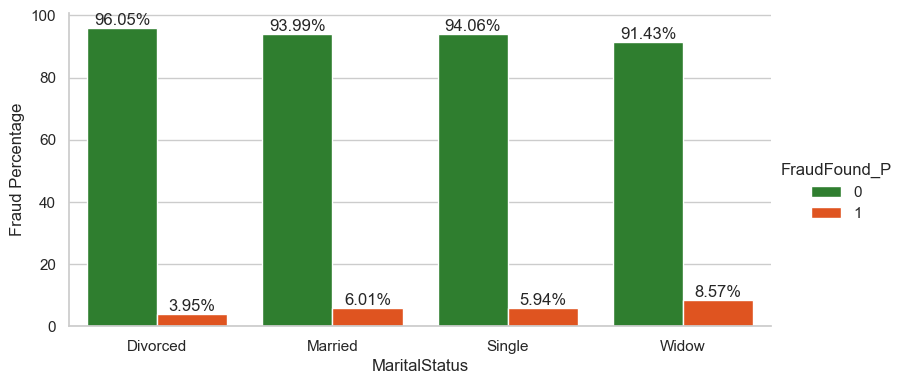

In [76]:
fraud_percentage("MaritalStatus", aspect=2)

Generally fraud percentage seem to not differ too much for the different categories of marital status, which isn't unexpected, since marital status should not have much influence on whether fraud is committed

### PoliceReportFiled

In [77]:
df_prf = df[["PoliceReportFiled", "FraudFound_P"]]
df_prf.head()

,PoliceReportFiled,FraudFound_P
0,No,0
1,Yes,0
2,No,0
3,Yes,0
4,No,0


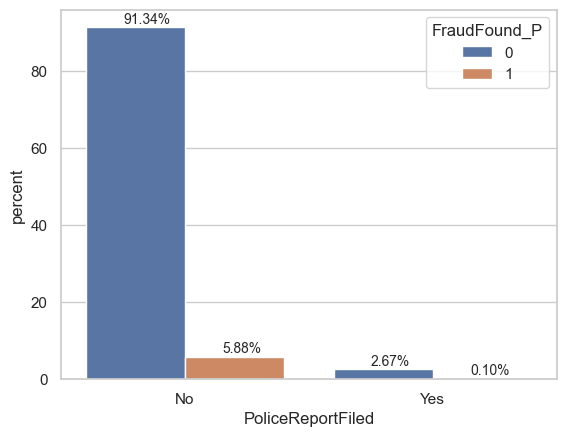

In [78]:
ax = sns.countplot(x="PoliceReportFiled", data=df, hue="FraudFound_P", stat="percent")
for p in ax.patches: # Annotating counts (p.get_height) onto graph and formatting their positions 
    value = "{:,.2f}%".format(p.get_height())
    if value != "0.00%":
        ax.annotate(value, (p.get_x() + p.get_width() - 0.25, p.get_height() + 2), va="center", fontsize=10) 

plt.show()

PoliceReportFiled could potentially be a good variable to inform us if a claim is fraudulent or not. Comparing both reported and not reported, we can clearly see that there is a higher percentage of fraud cases in those that are not reported, compared to those that were. This makes sense intuitively as people who are attempting fraud would not want any thorough investigations by authorities that can invalidate their fraud claims

order = ["1 vehicle", "2 vehicles", "3 to 4", "5 to 8", "more than 8"]
fraud_freq = df.groupby("NumberOfCars")["FraudFound_P"].mean().reset_index()

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,8))

ax1 = sns.countplot(x="NumberOfCars", data=df, hue="FraudFound_P", stat="percent", order=order, ax=ax1)
for p in ax1.patches: # Annotating counts (p.get_height) onto graph and formatting their positions 
    value = "{:,.2f}%".format(p.get_height())
    if value != "0.00%":
        ax1.annotate(value, (p.get_x() + p.get_width() - 0.37, p.get_height() + 1.5), va="center", fontsize=10) 

ax2 = sns.barplot(x="NumberOfCars", y="FraudFound_P", data=fraud_freq, order=order, ax=ax2)
for p in ax2.patches: # Annotating counts (p.get_height) onto graph and formatting their positions 
    value = round(p.get_height(), 5) * 100
    ax2.annotate(value, (p.get_x() + p.get_width() - 0.6, p.get_height() + 0.002), va="center", fontsize=10) 

plt.xticks(rotation=45)
plt.show()

In [79]:
df_ncar = df[["NumberOfCars", "FraudFound_P"]]
df_ncar.head()

,NumberOfCars,FraudFound_P
0,3 to 4,0
1,1 vehicle,0
2,1 vehicle,0
3,1 vehicle,0
4,1 vehicle,0


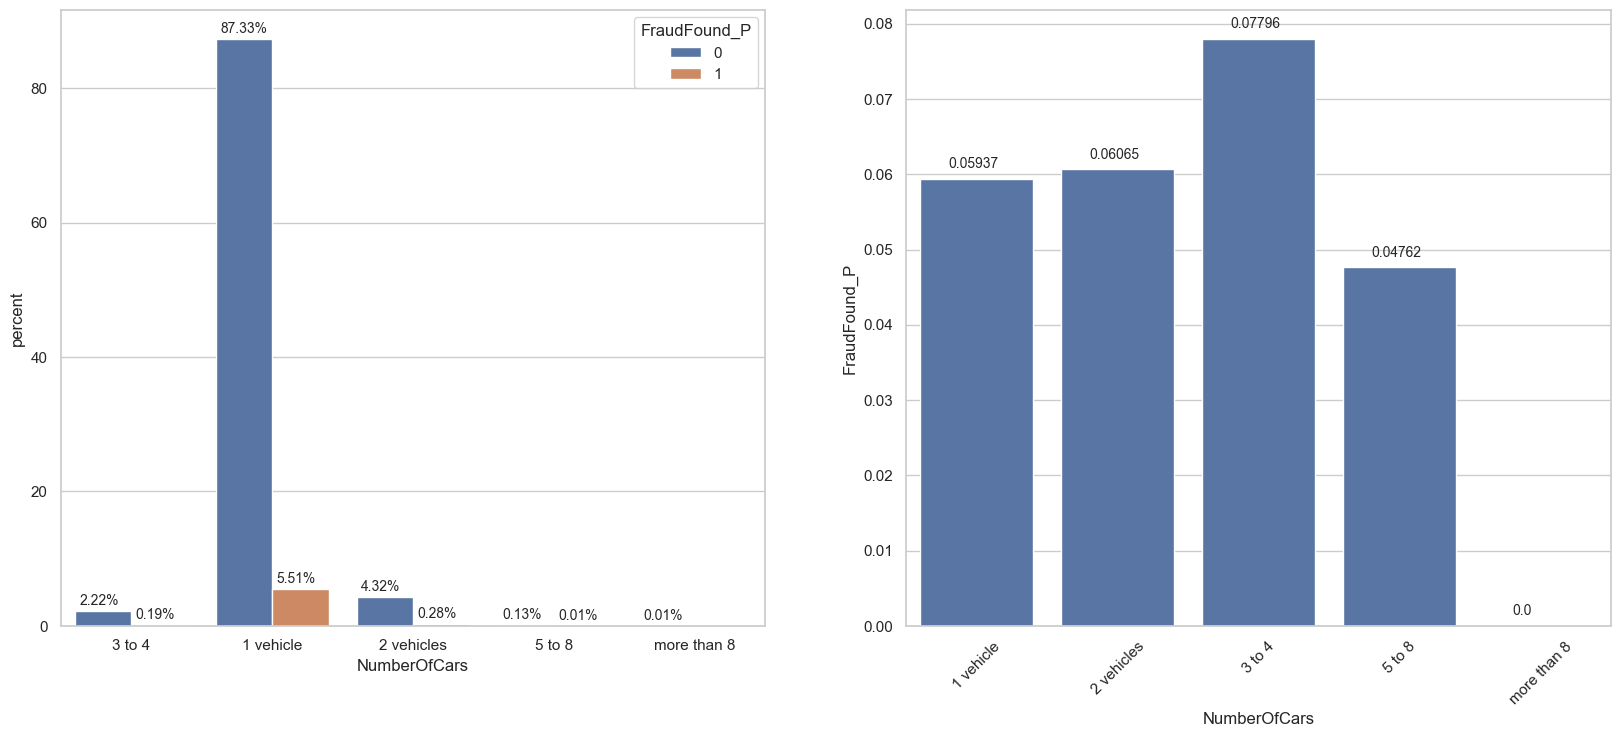

In [137]:
order = ["1 vehicle", "2 vehicles", "3 to 4", "5 to 8", "more than 8"]
fraud_freq = df.groupby("NumberOfCars")["FraudFound_P"].mean().reset_index()

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,8))

ax1 = sns.countplot(x="NumberOfCars", data=df, hue="FraudFound_P", stat="percent", ax=ax1)
for p in ax1.patches: # Annotating counts (p.get_height) onto graph and formatting their positions 
    value = "{:,.2f}%".format(p.get_height())
    if value != "0.00%":
        ax1.annotate(value, (p.get_x() + p.get_width() - 0.37, p.get_height() + 1.5), va="center", fontsize=10) 

ax2 = sns.barplot(x="NumberOfCars", y="FraudFound_P", data=fraud_freq, ax=ax2)
for p in ax2.patches: # Annotating counts (p.get_height) onto graph and formatting their positions 
    value = round(p.get_height(), 5)
    ax2.annotate(value, (p.get_x() + p.get_width() - 0.6, p.get_height() + 0.002), va="center", fontsize=10) 

plt.xticks(rotation=45)
plt.show()

### Feature importance for categorical variables in cat3 using chi-squared test

In [82]:
from sklearn.feature_selection import SelectKBest, chi2

y = df["FraudFound_P"]
categorical_features = ["Sex", "MaritalStatus", "AgentType", "WitnessPresent", "DriverRating", "AccidentArea", "PoliceReportFiled", "NumberOfCars"]
cat3_feats = df[categorical_features]

dummies = pd.get_dummies(cat3_feats)

best_feat = SelectKBest(score_func=chi2, k="all").fit(dummies, y)
feat_names = best_feat.get_feature_names_out()
feat_scores = best_feat.scores_
feat_pvalues = best_feat.pvalues_

chi2_df = pd.DataFrame({"names": feat_names, "scores": feat_scores, "pvalues": feat_pvalues})
chi2_df.head()

,names,scores,pvalues
0,DriverRating,0.410067,0.521936
1,Sex_Female,11.663620,0.000637
2,Sex_Male,2.171228,0.140614
3,MaritalStatus_Divorced,0.561133,0.453804
4,MaritalStatus_Married,0.015212,0.901840


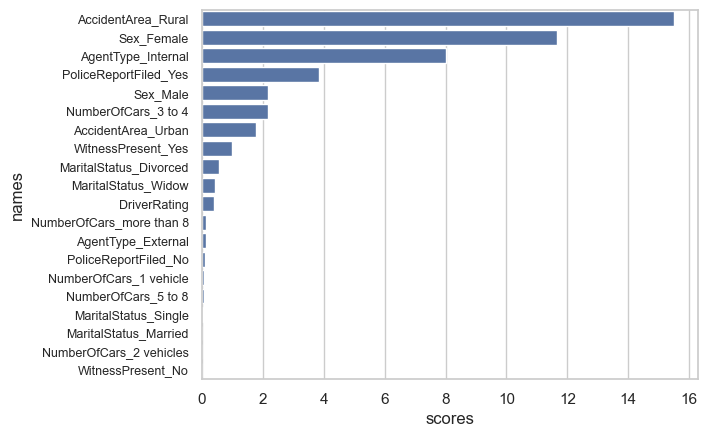

In [83]:
chi2_df_SortByScore = chi2_df.sort_values(by="scores", ascending=False)
sns.barplot(x="scores", y="names", data=chi2_df_SortByScore)
plt.yticks(fontsize=9)
plt.show()

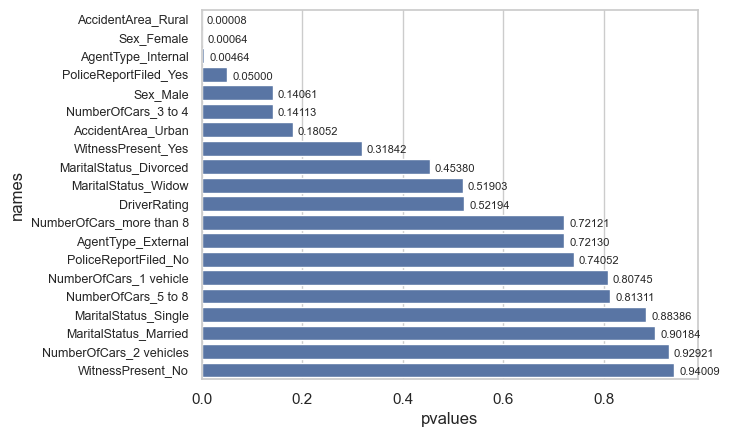

In [84]:
chi2_df_SortBypvalue = chi2_df.sort_values(by="pvalues")

ax = sns.barplot(x="pvalues", y="names", data=chi2_df_SortBypvalue)
for p in ax.patches: # Annotating counts (p.get_height) onto graph and formatting their positions 
    value = "{:,.5f}".format(p.get_width())
    ax.annotate(value, (p.get_x() + p.get_width() + 0.01, p.get_y() + 0.5), va="center", fontsize=8) 
        
plt.yticks(fontsize=9)
plt.show()

We can see that AccidentArea, Sex and AgentType have p-values < 0.05, and we can conclude that these features are related to FraudFound_P.

## Distribution of numerical columns

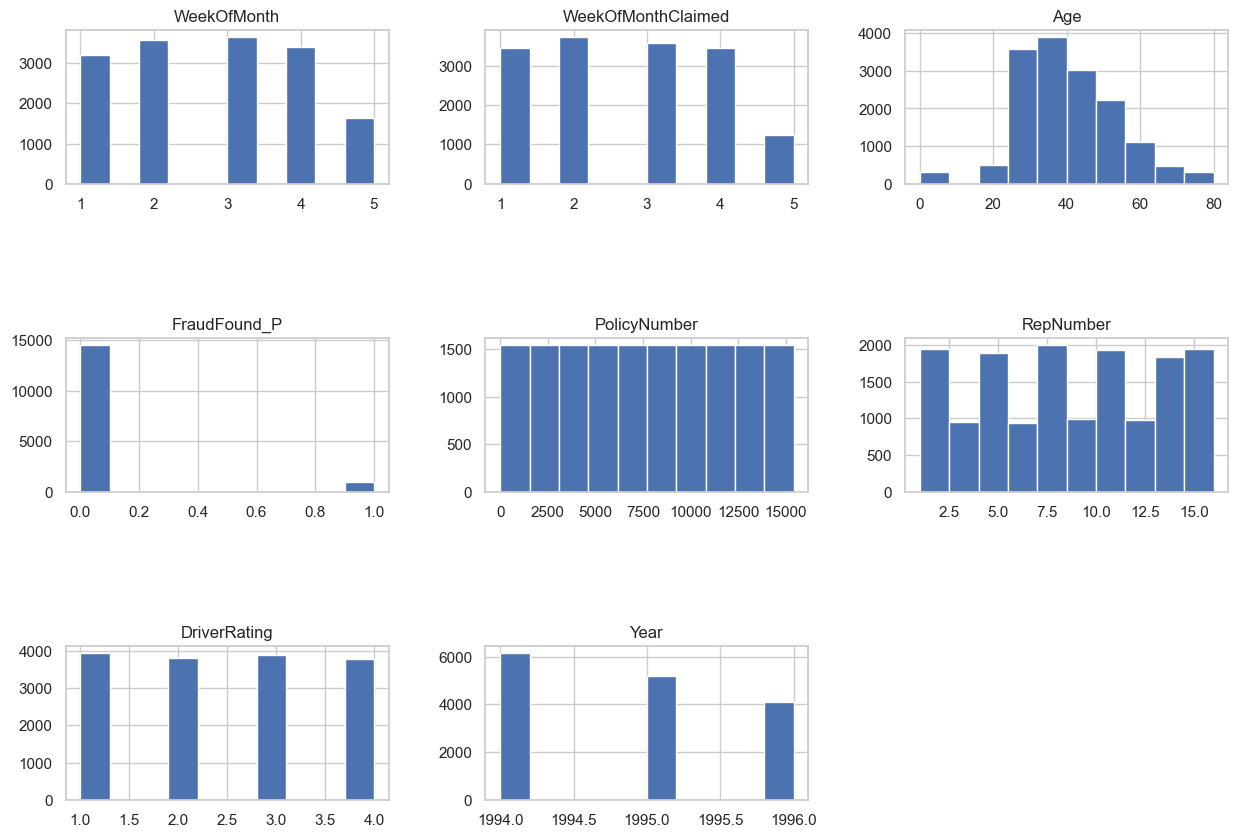

In [85]:
df_numerical = df[numerical_columns]

df_numerical.hist(figsize=(15,10))
plt.subplots_adjust(hspace=1)
plt.show()

## Distribution of Obj Columns

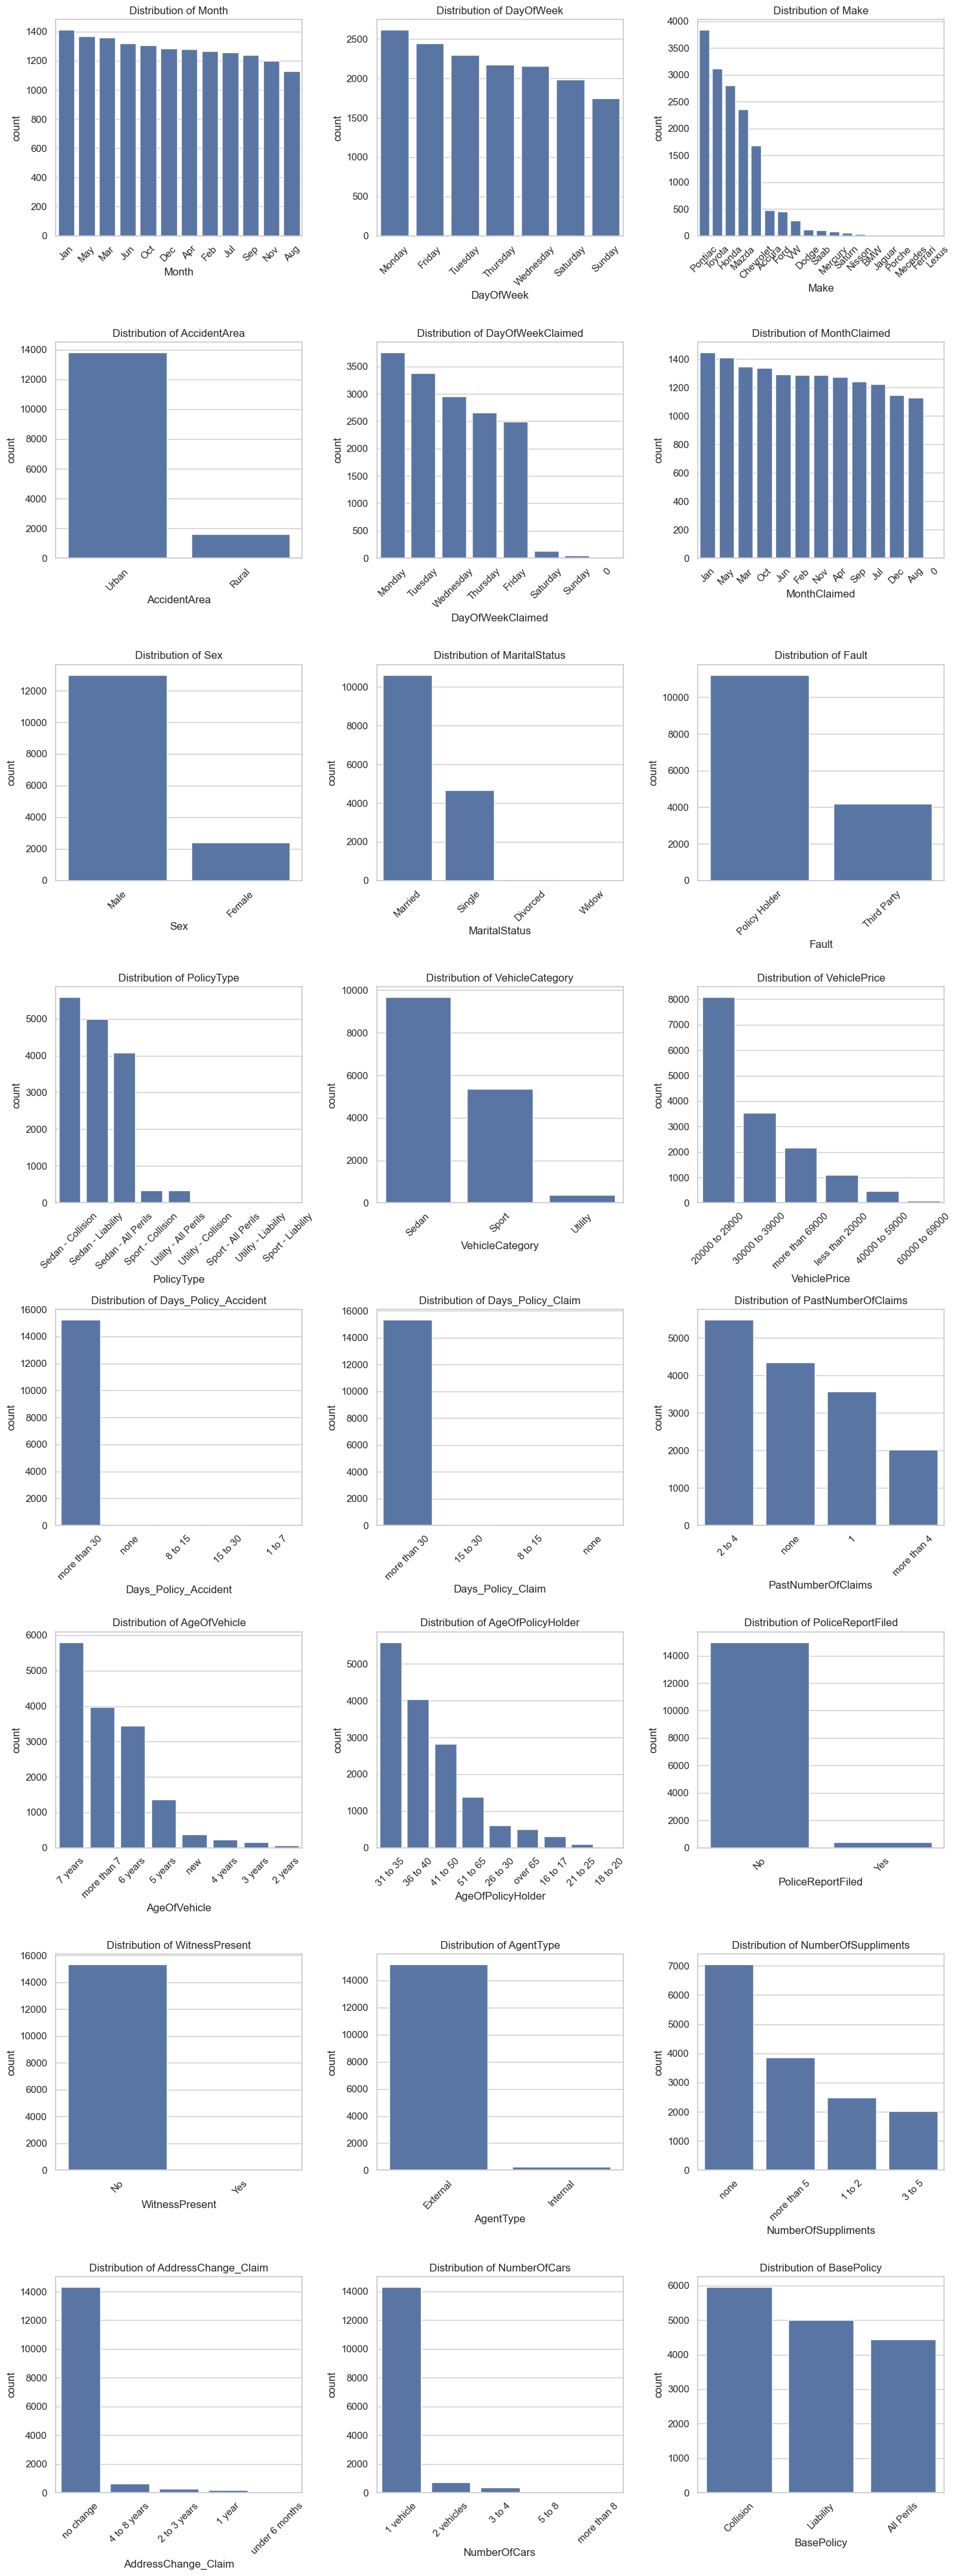

In [86]:
ncols = 3 # number of columns in graph grid

nrows = (len(obj_columns) + ncols - 1) // ncols  # Calculate the number of rows needed
    
plt.figure(figsize=(15, 5 * nrows))  # Adjust the figure size based on the number of rows

for i, col in enumerate(obj_columns, 1):
    plt.subplot(nrows, ncols, i)
    sns.countplot(x=col, data=df, order=df[col].value_counts().index)
    plt.xticks(rotation=45)
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

#### Austin - PolicyType, PolicyNumber, RepNumber, Deductible, Days_policy_accident, days_policy_claim

### PolicyType

In [87]:
df['PolicyType'].unique()

array(['Sport - Liability', 'Sport - Collision', 'Sedan - Liability',
       'Utility - All Perils', 'Sedan - All Perils', 'Sedan - Collision',
       'Utility - Collision', 'Utility - Liability', 'Sport - All Perils'],
      dtype=object)

<Axes: xlabel='PolicyType', ylabel='count'>

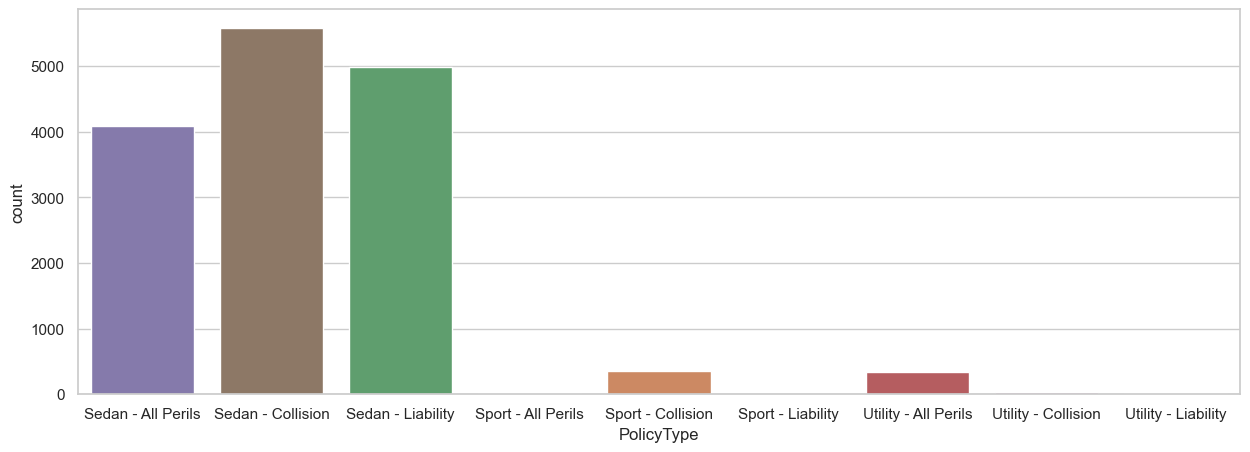

In [88]:
plt.figure(figsize=(15, 5))
sns.countplot(x="PolicyType", data=df, hue="PolicyType", legend=False, order = sorted(df["PolicyType"].unique()))

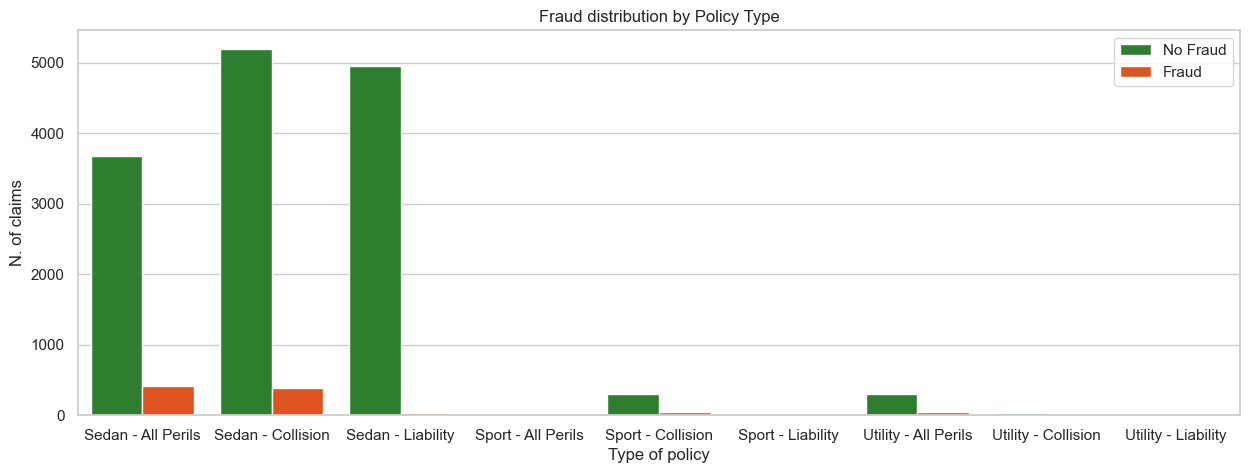

In [89]:
plt.figure(figsize=(15, 5))
labels = ['No Fraud', 'Fraud']
sns.countplot(x="PolicyType",hue="FraudFound_P" ,data=df, order = sorted(df["PolicyType"].unique()), palette={0:"forestgreen",1:"orangered"})
plt.legend(labels)
plt.title('Fraud distribution by Policy Type')
plt.xlabel('Type of policy')
plt.ylabel('N. of claims')
plt.show()

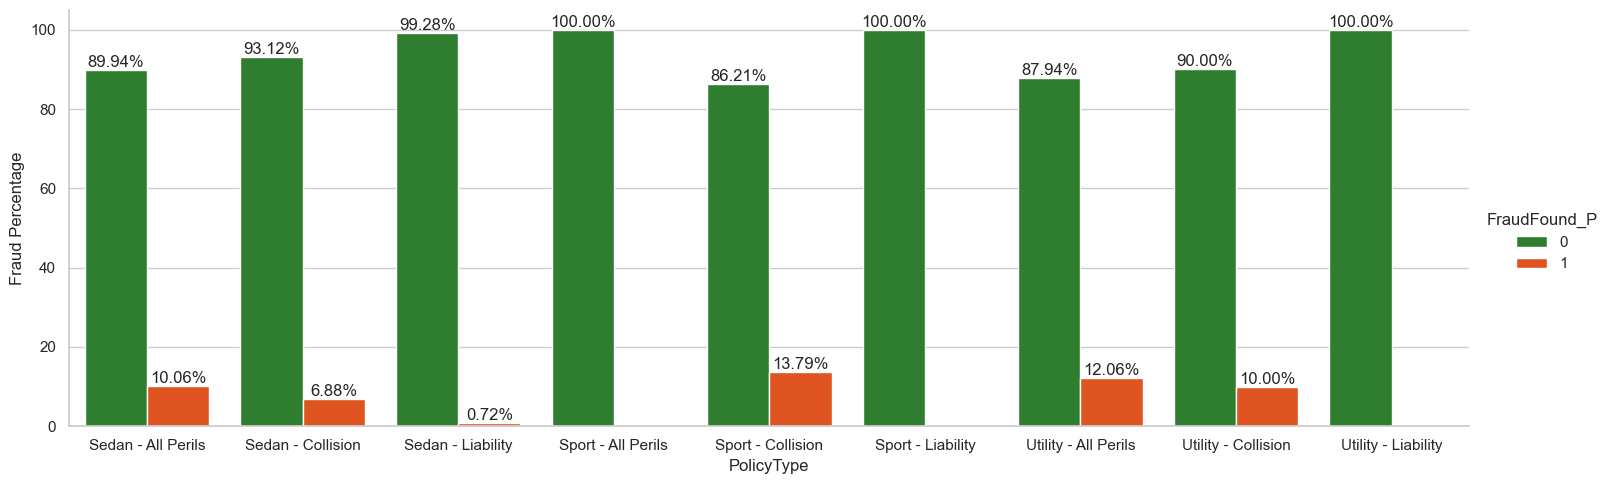

In [90]:
fraud_percentage("PolicyType", height=5, aspect=3)

Most policies are held for sedan type of cars. Most interesting observation is that for Sedan - Liability, percentage of fraud found is much lower compared to the other policy types which has a fraud rate of around 10%

### PolicyNumber

In [91]:
df['PolicyNumber'].nunique()

15420

All values of PolicyNumber are unique so not much insights to be gained here.

### RepNumber

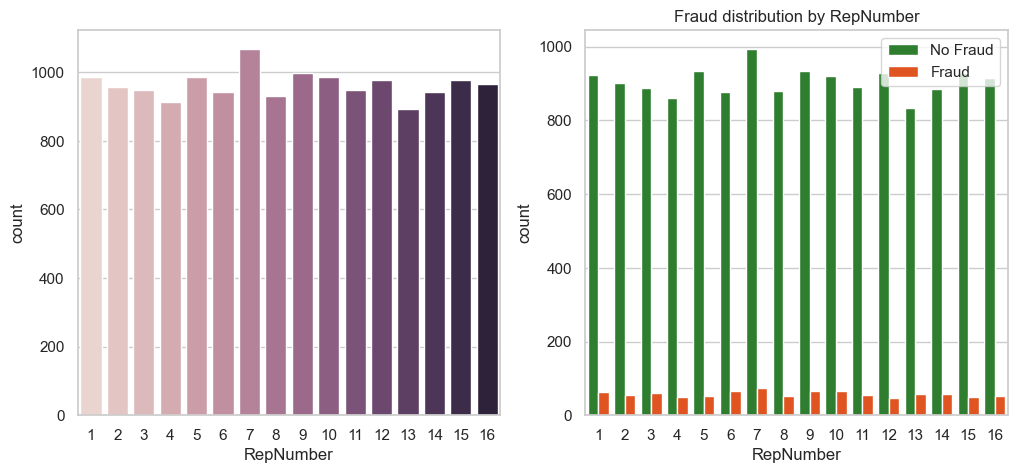

In [117]:
dist_by_col("RepNumber", (12,5))

Number of policies managed by each representative is roughly the same. Fraud distribution seems to be the same across the different representative

### Deductible

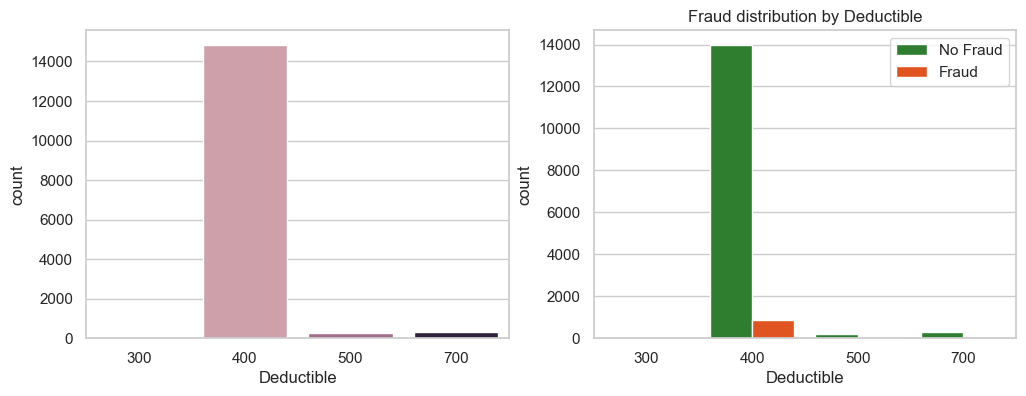

In [121]:
dist_by_col("Deductible", (12,4))

### Days_Policy_Accident

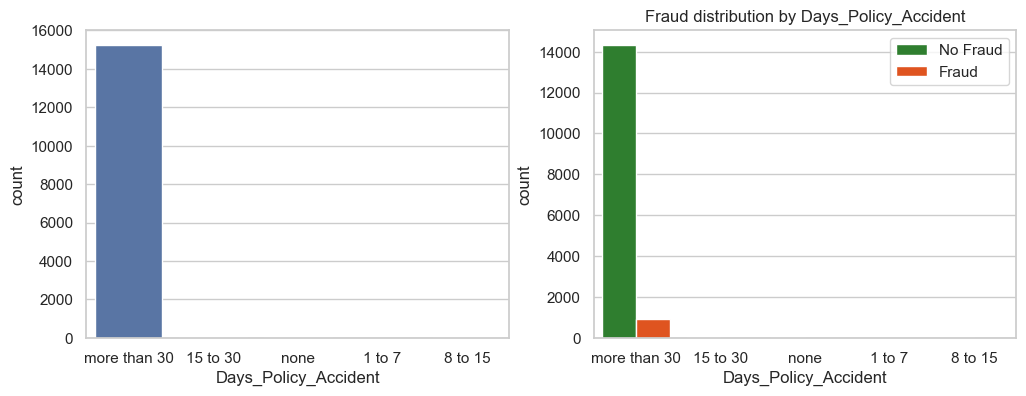

In [120]:
dist_by_col("Days_Policy_Accident", (12,4))

Most accidents occured more than 30 days after policy started. Perhaps fraudsters know that it would be too obvious if an accident happened right after a policy was bought

### Days_Policy_Claim

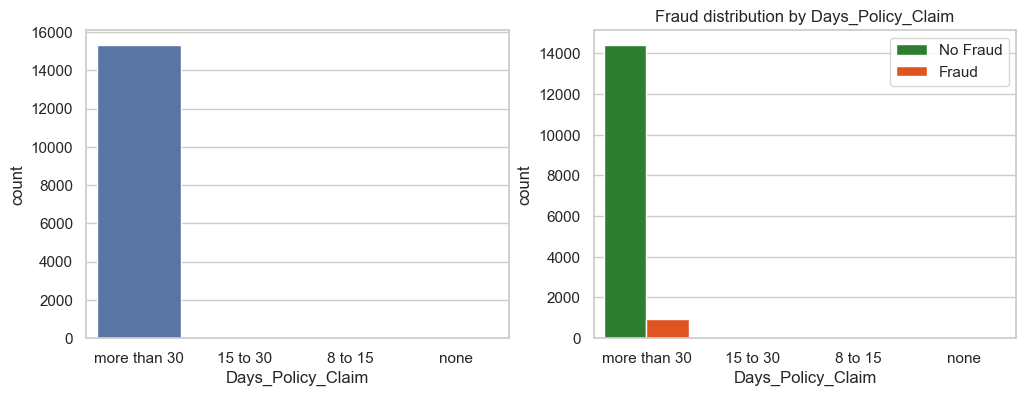

In [122]:
dist_by_col("Days_Policy_Claim", (12,4))

Most policies have more than 30 days in which policy can be claimed. 

In [96]:
def chi_square_test(df, column, alpha=0.05):
    contingency_table = pd.crosstab(df[column], df["FraudFound_P"])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"\nChi-square test for {column}:\n")
    print(f"Chi-square statistic: {chi2}")
    print(f"P-value: {p}")
    if p <= alpha:
        print("Result is statistically significant at alpha =", alpha)
    else:
        print("Result is not statistically significant at alpha =", alpha)
for col in ["PolicyType", "RepNumber", "Deductible", "Days_Policy_Accident", "Days_Policy_Claim", "AgentType", "MaritalStatus"]:
    chi_square_test(df, col, alpha=0.05)


Chi-square test for PolicyType:

Chi-square statistic: 437.40187033464593
P-value: 1.848256360377509e-89
Result is statistically significant at alpha = 0.05

Chi-square test for RepNumber:

Chi-square statistic: 11.81963998384649
P-value: 0.6926264603120778
Result is not statistically significant at alpha = 0.05

Chi-square test for Deductible:

Chi-square statistic: 72.4151799153973
P-value: 1.2971078088687856e-15
Result is statistically significant at alpha = 0.05

Chi-square test for Days_Policy_Accident:

Chi-square statistic: 11.57160700948295
P-value: 0.02083813005487907
Result is statistically significant at alpha = 0.05

Chi-square test for Days_Policy_Claim:

Chi-square statistic: 4.881178758356895
P-value: 0.1807074699436798
Result is not statistically significant at alpha = 0.05

Chi-square test for AgentType:

Chi-square statistic: 7.37951846090607
P-value: 0.006597083165013743
Result is statistically significant at alpha = 0.05

Chi-square test for MaritalStatus:

Chi-squ

## Daniel -- PastNumberOfClaims - AddressChangeClaim

In [97]:
df.columns

Index(['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea',
       'DayOfWeekClaimed', 'MonthClaimed', 'WeekOfMonthClaimed', 'Sex',
       'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory',
       'VehiclePrice', 'FraudFound_P', 'PolicyNumber', 'RepNumber',
       'Deductible', 'DriverRating', 'Days_Policy_Accident',
       'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle',
       'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType',
       'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'Year',
       'BasePolicy'],
      dtype='object')

In [98]:
numerical_columns = ['Age']
category_columns = ['PastNumberOfClaims', 'BasePolicy', 'AgeOfPolicyHolder', 'NumberOfSuppliments', 'AddressChange_Claim', 'Sex']

In [99]:
for col in category_columns:
    # get number of null values
    print(f"Number of null values in {col}: {df[col].isnull().sum()}")
    # get unique values
    print(f"Unique values in {col}: {df[col].unique()}\n")

Number of null values in PastNumberOfClaims: 0
Unique values in PastNumberOfClaims: ['none' '1' '2 to 4' 'more than 4']

Number of null values in BasePolicy: 0
Unique values in BasePolicy: ['Liability' 'Collision' 'All Perils']

Number of null values in AgeOfPolicyHolder: 0
Unique values in AgeOfPolicyHolder: ['26 to 30' '31 to 35' '41 to 50' '51 to 65' '21 to 25' '36 to 40'
 '16 to 17' 'over 65' '18 to 20']

Number of null values in NumberOfSuppliments: 0
Unique values in NumberOfSuppliments: ['none' 'more than 5' '3 to 5' '1 to 2']

Number of null values in AddressChange_Claim: 0
Unique values in AddressChange_Claim: ['1 year' 'no change' '4 to 8 years' '2 to 3 years' 'under 6 months']

Number of null values in Sex: 0
Unique values in Sex: ['Female' 'Male']



From this, we observe that the data for these columsn are relatively clean, and does have invalid or weird values. We can hence straight away get started into exploring the relationship of these columns with fraud.

In [100]:
def count_value_in_column(df, column):
    print(f"\nValue Counts for {column}:\n")
    print(df[column].value_counts())

for col in (numerical_columns+category_columns):
    count_value_in_column(df, col)


Value Counts for Age:

Age
30    596
33    574
34    573
35    569
28    560
     ... 
20     28
70     27
79     20
16      9
17      6
Name: count, Length: 66, dtype: int64

Value Counts for PastNumberOfClaims:

PastNumberOfClaims
2 to 4         5485
none           4352
1              3573
more than 4    2010
Name: count, dtype: int64

Value Counts for BasePolicy:

BasePolicy
Collision     5962
Liability     5009
All Perils    4449
Name: count, dtype: int64

Value Counts for AgeOfPolicyHolder:

AgeOfPolicyHolder
31 to 35    5593
36 to 40    4043
41 to 50    2828
51 to 65    1392
26 to 30     613
over 65      508
16 to 17     320
21 to 25     108
18 to 20      15
Name: count, dtype: int64

Value Counts for NumberOfSuppliments:

NumberOfSuppliments
none           7047
more than 5    3867
1 to 2         2489
3 to 5         2017
Name: count, dtype: int64

Value Counts for AddressChange_Claim:

AddressChange_Claim
no change         14324
4 to 8 years        631
2 to 3 years        291
1 

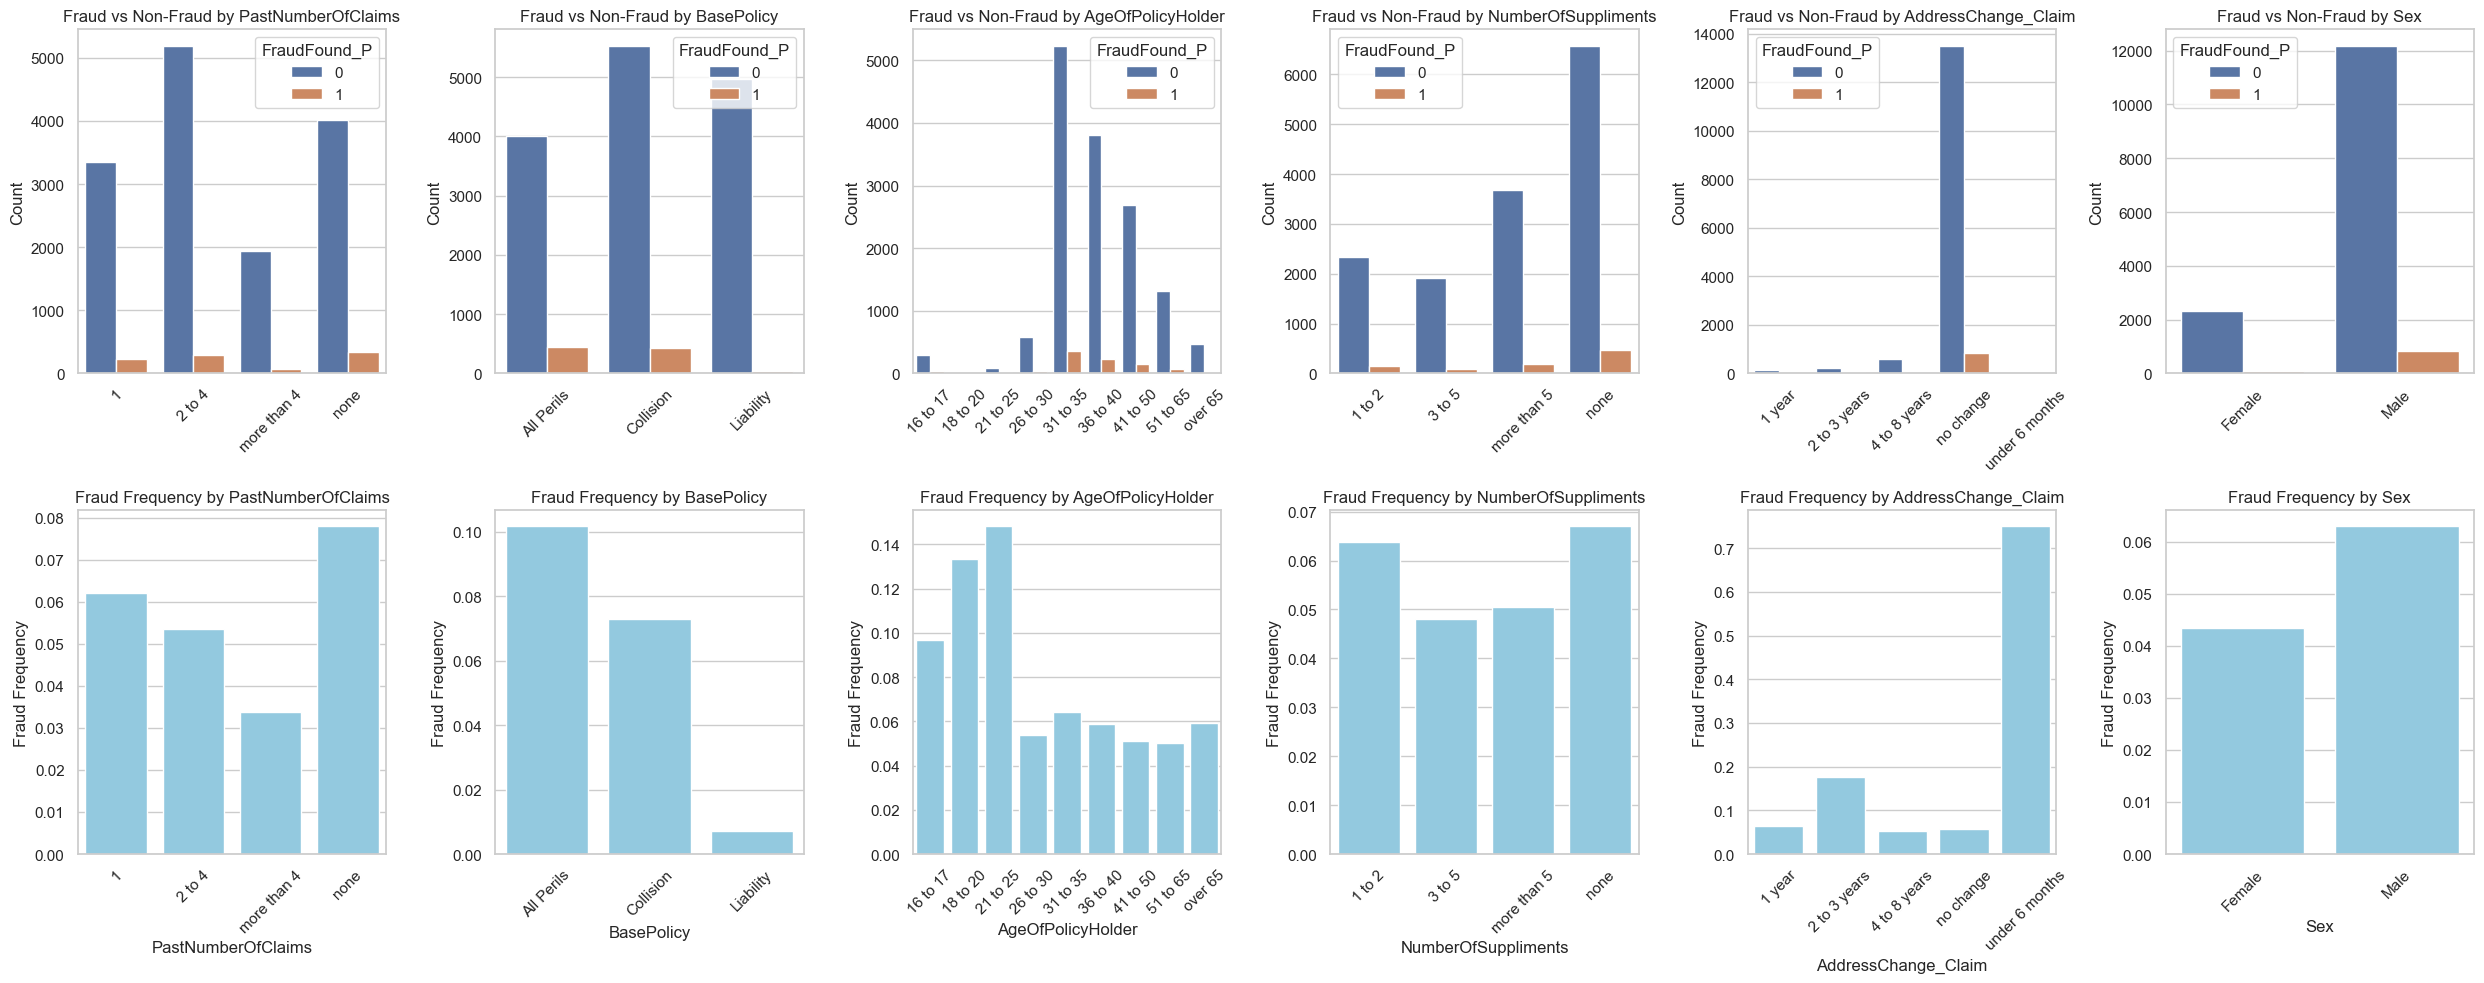

In [101]:
# Create a figure with subplots
plt.figure(figsize=(25, 10))
for i, column in enumerate(category_columns, 1):
    # Grouped bar graph
    plt.subplot(2, len(category_columns), i)
    temp_df = df.groupby([column, 'FraudFound_P']).size().reset_index(name='Count')
    sns.barplot(x=column, y='Count', hue='FraudFound_P', data=temp_df)
    plt.xticks(rotation=45)
    plt.title(f'Fraud vs Non-Fraud by {column}')
    plt.xlabel('')  # Hide x-axis label to save space
    
    # Fraud frequency graph
    plt.subplot(2, len(category_columns), i + len(category_columns))
    fraud_freq = df.groupby(column)['FraudFound_P'].mean().reset_index()
    sns.barplot(x=column, y='FraudFound_P', data=fraud_freq, color='skyblue')
    plt.xticks(rotation=45)
    plt.title(f'Fraud Frequency by {column}')
    plt.ylabel('Fraud Frequency')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


The graph plots the fraud frequency of each category in each variable. We note the following:
1. **PastNumberOfClaims:** The fraud frequency decreases with an increasing past number of claims. This suggests that fraudulent users are more likely to do fraud on the first claim. This has 2 likely possible reasons.

    1) Fraudulent users tend to be new users, and they probably create a new account under multiple different insurance groups, and do a fraudulent claim straight away. 
    2) New users might "accidentally" commit fraud, as they may not be properly aware of the insurance policy (less likely to be true, but possible)

2. **BasePolicy:** The fraud frequency for the liability policy is unusually low. This makes sense as liabilities coverage only protects third parties in an accident, and doesn't include one's own vehicle. This makes conducting fraud more difficult as more parties have to get involved, which increases the risk of the fraud getting discovered as well. On the other hand, All Perils coverage has the highest fraud frequency. All Perils covers all accident types, and hence is the easiest to do insurance fraud. For example, claiming extra damages that may have occurred from events other than the event one is claiming for.

3. **AgeOfPolicyHolder:** Policy Holders with ages 16-25 have a significantly higher fraud frequency compared to other ages. This may corroborate and be related with the data from `PastNumberOfClaims`, and hints that fraud happens with newer users.

4. **NumberOfSuppliments:** This is a number representing extra repairs or changes that were not included in the original estimate or insurance plan. I.e. extra repairs that were not identified or included in the initial assessment. The fraud rate for `None` and `1 to 2` is much higher than those 3 and above. This suggests that fraudulent claims happen without too much "extra charges". This probably happens because: 
    - Fraudulent users may want to avoid additional documentation that may be associated with extra charges (since whatever they want to claim for probably did not happen, and getting a second assessment may give away that there is fraud)
    - Fraudulent users probably would want to include their fraudulent claims as part of the initial damages during the initial assessment, as that is the first time damages are assessed.

5. **AddressChange_Claim:** A significant number of fraudulent claims happen for users which had changed their address in the last 6 months. This may be to avoid giving away their real actual address to hide their location, or that this may be involved in the fraud process as well. (Perhaps some users may do a double claim under different addresses, or even do an account takeover of a real user in the accident, and wrongly take their insurance claims for themselves)
    - However, it is to be noted that the sample size for `last 6 months` is only **4**. Hence, the results may not be as significant as it seems.

6. **Sex:** Males are slightly more likely to conduct fraud compared to females.


### Now, some statistical tests are conducted to find statistically significant variables. Since all the variables investigated in this section is categorical, Chi-Square test will be used.
The null hypothesis will be that there is no association between the categorical variable and fraud. We assume that all observations are independent. Pearson's Chi-Square statistic is used here.


In [102]:
def chi_square_test(df, column, alpha=0.05):
    contingency_table = pd.crosstab(df[column], df["FraudFound_P"])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"\nChi-square test for {column}:\n")
    print(f"Chi-square statistic: {chi2}")
    print(f"P-value: {p}")
    if p <= alpha:
        print("Result is statistically significant at alpha =", alpha)
        return True
    else:
        print("Result is not statistically significant at alpha =", alpha)
        return False

for col in category_columns:
    chi_square_test(df, col, alpha=0.05)



Chi-square test for PastNumberOfClaims:

Chi-square statistic: 53.500831251899115
P-value: 1.4337179439711136e-11
Result is statistically significant at alpha = 0.05

Chi-square test for BasePolicy:

Chi-square statistic: 402.8519212497997
P-value: 3.3251924714277856e-88
Result is statistically significant at alpha = 0.05

Chi-square test for AgeOfPolicyHolder:

Chi-square statistic: 33.003253564908285
P-value: 6.150519521424798e-05
Result is statistically significant at alpha = 0.05

Chi-square test for NumberOfSuppliments:

Chi-square statistic: 18.14057151499124
P-value: 0.0004114406212927169
Result is statistically significant at alpha = 0.05

Chi-square test for AddressChange_Claim:

Chi-square statistic: 104.73377284263451
P-value: 9.652105457759639e-22
Result is statistically significant at alpha = 0.05

Chi-square test for Sex:

Chi-square statistic: 13.489893718354447
P-value: 0.00023985178051231308
Result is statistically significant at alpha = 0.05


From this, we can reject the null hypothesis for all 6 variables here, and conclude that at 95% confidence, the 6 columns have some correlation with fraud. We will expect these features to be useful to our machine learning models in indentifing fraud.

In [103]:
# Using Cramers_V to calculate the strength of association between two categorical variables
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    r_corr = r - ((r-1)**2)/(n-1)
    k_corr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))

for col in category_columns:
    print(f"\nCramer's V for {col} and FraudFound_P:", cramers_v(df[col], df["FraudFound_P"]))


Cramer's V for PastNumberOfClaims and FraudFound_P: 0.057229549001259226

Cramer's V for BasePolicy and FraudFound_P: 0.1612366666660834

Cramer's V for AgeOfPolicyHolder and FraudFound_P: 0.040268518617550604

Cramer's V for NumberOfSuppliments and FraudFound_P: 0.0313357606030138

Cramer's V for AddressChange_Claim and FraudFound_P: 0.08082745185247789

Cramer's V for Sex and FraudFound_P: 0.028460999032154325


This suggests that although there is an association with the different features on fraud occurence, the strength of association is somewhat negligible. Only the `Base Policy` feature appears to have a somewhat weak association. This means this will probably be a secondary associative feature to be used.

In [104]:
from sklearn.feature_selection import SelectKBest, chi2

y = df["FraudFound_P"]
# numerical_columns
category_columns = ['PastNumberOfClaims', 'BasePolicy', 'AgeOfPolicyHolder', 'NumberOfSuppliments', 'AddressChange_Claim', 'Sex']
feats = df[numerical_columns]

dummies = pd.get_dummies(feats)

best_feat = SelectKBest(score_func=chi2, k="all").fit(dummies, y)
feat_names = best_feat.get_feature_names_out()
feat_scores = best_feat.scores_
feat_pvalues = best_feat.pvalues_

chi2_df = pd.DataFrame({"names": feat_names, "scores": feat_scores, "pvalues": feat_pvalues})
chi2_df.head()

,names,scores,pvalues
0,Age,62.295705,2.955690e-15


Now, lets begin analysis for the numerical type, `Age`:


Summary Statistics for Age:
count    15420.000000
mean        39.855707
std         13.492377
min          0.000000
25%         31.000000
50%         38.000000
75%         48.000000
max         80.000000
Name: Age, dtype: float64


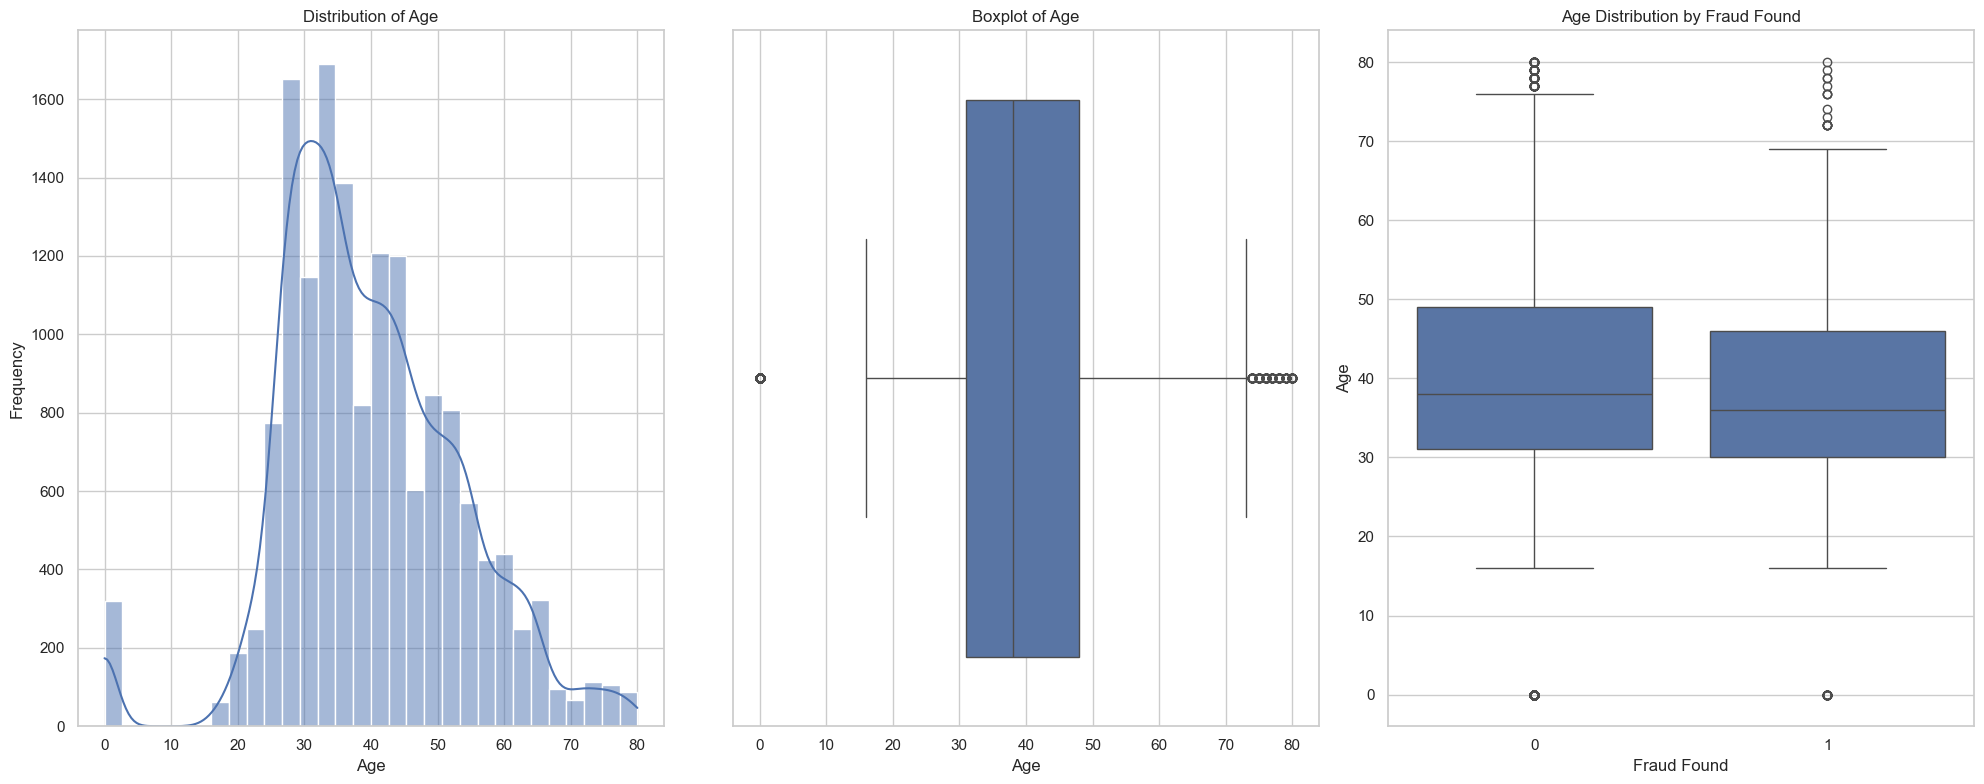

In [105]:
# Summary statistics
print("Summary Statistics for Age:")
print(df['Age'].describe())

fig, axs = plt.subplots(1, 3, figsize=(20, 8))

# Histogram with KDE
sns.histplot(df['Age'], kde=True, bins=30, ax=axs[0])
axs[0].set_title('Distribution of Age')
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Frequency')

# Boxplot
sns.boxplot(x=df['Age'], ax=axs[1])
axs[1].set_title('Boxplot of Age')
axs[1].set_xlabel('Age')

# Boxplot showing relationship with the target variable
sns.boxplot(x='FraudFound_P', y='Age', data=df, ax=axs[2])
axs[2].set_title('Age Distribution by Fraud Found')
axs[2].set_xlabel('Fraud Found')
axs[2].set_ylabel('Age')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


From this, we observe that quite a significant number of entries are of Age == 0. This is anomalous, so let's investigate it's relationship with `AgeOfPolicyHolder` to determine if they refer to the same person or are they different people. Another insight we get is that the general age distribution of fraudulent users are younger than non fraudulent users.


In [106]:
age_zero_df = df[df['Age'] == 0]
age_zero_distribution = age_zero_df['AgeOfPolicyHolder'].value_counts()
print("Distribution of AgeOfPolicyHolder for cases where Age is 0:")
print(age_zero_distribution)


Distribution of AgeOfPolicyHolder for cases where Age is 0:
AgeOfPolicyHolder
16 to 17    320
Name: count, dtype: int64


We observe that all rows with Age == 0, the Age Of Policy Holder is from 16-17, which means that the age value is not within the policy holder's age group. Let's verify if there is a relationship between the 2 for other ages as well.

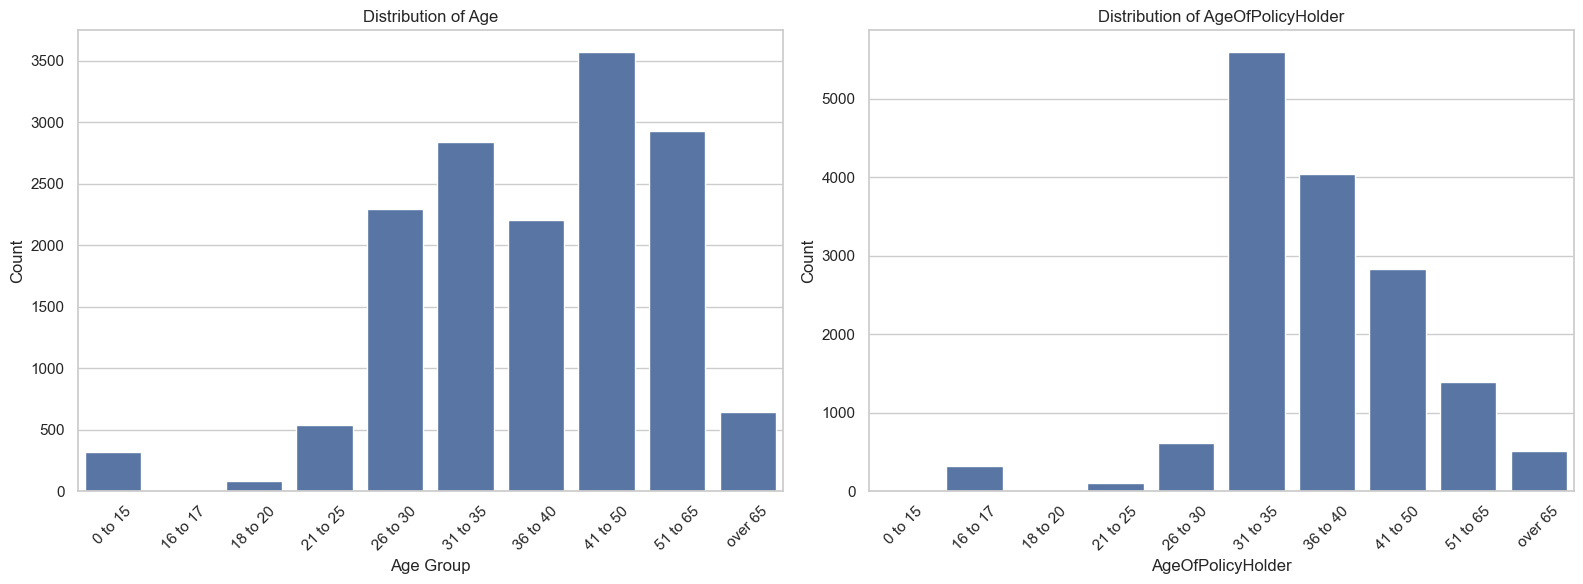

In [107]:
# Define age group bins and labels, including an extra "0 to 15" group
bins = [0, 15, 17, 20, 25, 30, 35, 40, 50, 65, float('inf')]
labels = ['0 to 15', '16 to 17', '18 to 20', '21 to 25', '26 to 30', '31 to 35', '36 to 40', '41 to 50', '51 to 65', 'over 65']

# Bin the Age into corresponding groups to compare
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)


fig, axs = plt.subplots(1, 2, figsize=(16, 6), tight_layout=True)

# Age
sns.countplot(x='AgeGroup', data=df, ax=axs[0], order=labels)
axs[0].set_title('Distribution of Age')
axs[0].set_xlabel('Age Group')
axs[0].set_ylabel('Count')
axs[0].tick_params(axis='x', rotation=45)

# AgeOfPolicyHolder
sns.countplot(x='AgeOfPolicyHolder', data=df, ax=axs[1], order=labels)
axs[1].set_title('Distribution of AgeOfPolicyHolder')
axs[1].set_xlabel('AgeOfPolicyHolder')
axs[1].set_ylabel('Count')
axs[1].tick_params(axis='x', rotation=45)

plt.show()



Looking at the 2 distributions, we observe that there is unlikely to be any relationship between one's Age and it's group. The group and it's distribution are vastly different. From the datasheet, Age is defined as `Age of the person`. We can assume that the person in question is probably just the driver of the vehicle involved. The person may or may not be the same person as the policy holder. Now, lets investigate further into when the Age is 0, and see if there is any relation to fraud in this case.

Fraud Rates by Age Group:
IsAgeZero
Age 0         0.096875
Other Ages    0.059073
Name: FraudFound_P, dtype: float64


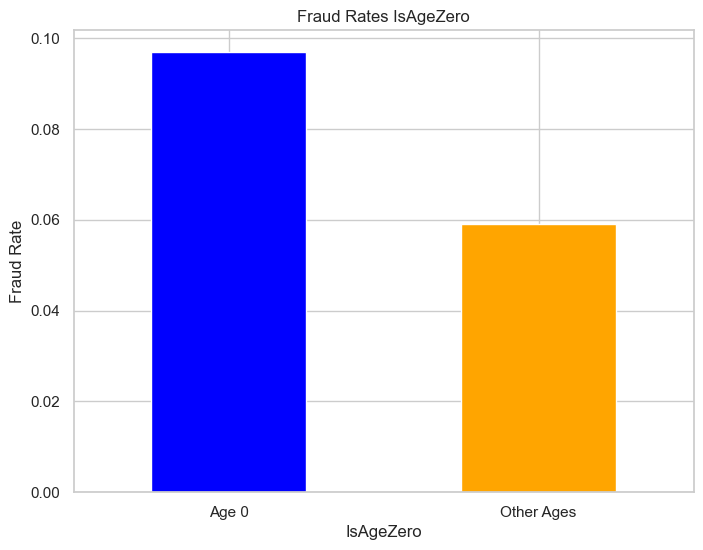

In [108]:
# Create a new column to categorize records by age group
df['IsAgeZero'] = df['Age'].apply(lambda x: 'Age 0' if x == 0 else 'Other Ages')

fraud_rate_by_age_group = df.groupby('IsAgeZero')['FraudFound_P'].mean()

# Print the fraud rates
print("Fraud Rates by Age Group:")
print(fraud_rate_by_age_group)

# Visualize the fraud rates
fraud_rate_by_age_group.plot(kind='bar', figsize=(8, 6), color=['blue', 'orange'])
plt.title('Fraud Rates IsAgeZero')
plt.xlabel('IsAgeZero')
plt.ylabel('Fraud Rate')
plt.xticks(rotation=0)
plt.show()


Those that are of `Age == 0` is about 2x more likely to be involved in Fraud. This is interesting, and hints that there is some relation to fraud when one's Age is 0. A good assumption to make is that age is set as 0 when the age is unknown. Perhaps the person claiming for insurance left the field empty to hide their indentity/fill up the form faster, and then a default value of 0 is entered instead. To preserve this information while still avoiding any bias from these outliers, we will do the following approach:
1. Impute Age == 0 with the mean Age
2. Introduce a flag for entries which originally had Age == 0.

In [109]:
df['AgeUnknown'] = df['Age'].apply(lambda x: "True" if x == 0 else "False") # Flag Variable
mean_age = df[df['Age'] != 0]['Age'].mean() # Exclude Age == 0 rows
df['Age'] = df['Age'].replace(0, mean_age)

## Descriptive Statistics

In [110]:
categorical_features = df.select_dtypes(include=['object']).columns

significant_features = []

for col in categorical_features:
    if chi_square_test(df, col, alpha=0.05):
        significant_features.append(col)
        print(f"Cramer's V for {col} and FraudFound_P:", cramers_v(df[col], df["FraudFound_P"]))
    else:
        print(f"{col} is not significant")


Chi-square test for Month:

Chi-square statistic: 29.796429273515734
P-value: 0.0017054796492372846
Result is statistically significant at alpha = 0.05
Cramer's V for Month and FraudFound_P: 0.03491413865596234

Chi-square test for DayOfWeek:

Chi-square statistic: 10.150635452564263
P-value: 0.11845009460632426
Result is not statistically significant at alpha = 0.05
DayOfWeek is not significant

Chi-square test for Make:

Chi-square statistic: 59.80999900179377
P-value: 2.195889371054876e-06
Result is statistically significant at alpha = 0.05
Cramer's V for Make and FraudFound_P: 0.05207219827051443

Chi-square test for AccidentArea:

Chi-square statistic: 16.84430956342229
P-value: 4.057480255422561e-05
Result is statistically significant at alpha = 0.05
Cramer's V for AccidentArea and FraudFound_P: 0.032055877319238646

Chi-square test for DayOfWeekClaimed:

Chi-square statistic: 5.159623216717765
P-value: 0.6404907095053917
Result is not statistically significant at alpha = 0.05
D

In [128]:
categorical_features

Index(['Month', 'DayOfWeek', 'Make', 'AccidentArea', 'DayOfWeekClaimed',
       'MonthClaimed', 'Sex', 'MaritalStatus', 'Fault', 'PolicyType',
       'VehicleCategory', 'VehiclePrice', 'Deductible', 'Days_Policy_Accident',
       'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle',
       'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType',
       'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars',
       'BasePolicy', 'IsAgeZero', 'AgeUnknown'],
      dtype='object')

In [111]:
significant_features

['Month',
 'Make',
 'AccidentArea',
 'MonthClaimed',
 'Sex',
 'Fault',
 'PolicyType',
 'VehicleCategory',
 'VehiclePrice',
 'Deductible',
 'Days_Policy_Accident',
 'PastNumberOfClaims',
 'AgeOfVehicle',
 'AgeOfPolicyHolder',
 'AgentType',
 'NumberOfSuppliments',
 'AddressChange_Claim',
 'BasePolicy',
 'IsAgeZero',
 'AgeUnknown']

In [112]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Month                 15420 non-null  object  
 1   WeekOfMonth           15420 non-null  int8    
 2   DayOfWeek             15420 non-null  object  
 3   Make                  15420 non-null  object  
 4   AccidentArea          15420 non-null  object  
 5   DayOfWeekClaimed      15420 non-null  object  
 6   MonthClaimed          15420 non-null  object  
 7   WeekOfMonthClaimed    15420 non-null  int8    
 8   Sex                   15420 non-null  object  
 9   MaritalStatus         15420 non-null  object  
 10  Age                   15420 non-null  float64 
 11  Fault                 15420 non-null  object  
 12  PolicyType            15420 non-null  object  
 13  VehicleCategory       15420 non-null  object  
 14  VehiclePrice          15420 non-null  object  
 15  Fr

In [113]:
from scipy.stats import pointbiserialr
# List of numerical columns
numerical_features = df.select_dtypes(include=['float64', 'int64', 'int8', 'int16', 'int32']).columns

# Initialize a dictionary to store significant features
significant_num_features = {}

# Set the significance level
alpha = 0.05

# Iterate over numerical features and calculate point-biserial correlation
for column in numerical_features:
    if df[column].nunique() > 2:  # For continuous variables
        correlation, p_value = df[column].corr(df["FraudFound_P"]), 0  # Using Pearson correlation
    else:  # For binary variables
        correlation, p_value = pointbiserialr(df[column], df["FraudFound_P"])
    if p_value < alpha:
        significant_num_features[column] = correlation

list(significant_num_features.items())

[('WeekOfMonth', -0.011861477541061732),
 ('WeekOfMonthClaimed', -0.005761020583100179),
 ('Age', -0.022122323202955072),
 ('FraudFound_P', 0.9999999999999805),
 ('PolicyNumber', -0.020344658507316312),
 ('RepNumber', -0.007551255628232317),
 ('DriverRating', 0.007266104312898494),
 ('Year', -0.02475966335377651)]

## Correlation Analysis

In [114]:
correlation = df['Age'].corr(df['FraudFound_P'])

correlation

-0.022122323202955072

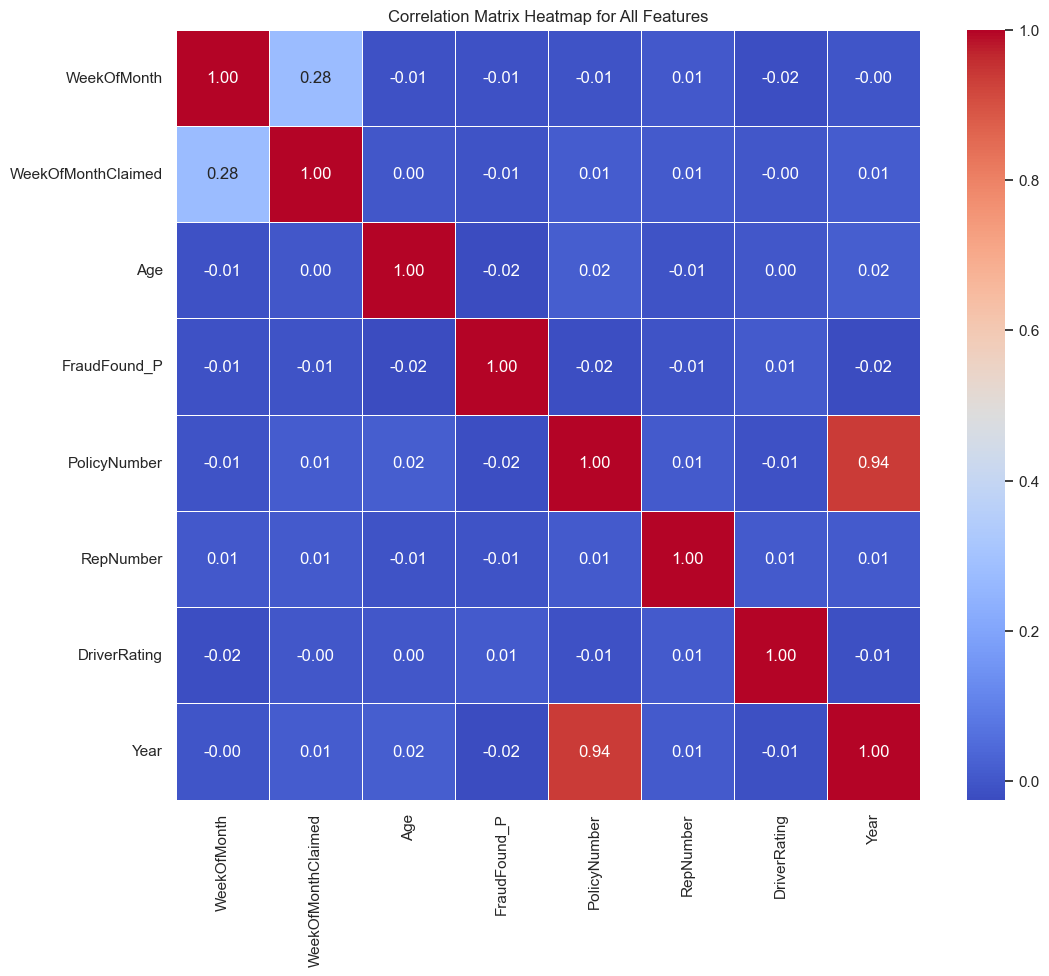

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame containing numerical columns
correlation_matrix = df.select_dtypes(include=['float64', 'int64', 'int8', 'int16', 'int32']).corr()

# Plotting heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix Heatmap for All Features')
plt.show()


## Hypothesis Testing (?)

## Conclusions